In [1]:
# imports, basic params
import os
import re
import seaborn  
import numpy as np
import matplotlib as mpl
from classes.runstruct import root_dir, ChromStruct
from likelihood.cllh_functions import predicted_pi
from precalc.lh_inputs import load_saved, prepare_inputs, adjust_arrays, split_index
from data_processing.functions import swap_root
from data_processing.data_tools import randint_unique, calculate_error
from results.rsq_maps import rsq_2

# increase plot dpi
mpl.rcParams['figure.dpi'] = 200
plt = mpl.pyplot

# plot colors to choose from
cols = ['HotPink', 'MediumVioletRed', 'Coral', 'OrangeRed', 'Cyan', 'Teal', 
        'MediumAquamarine', 'DarkGreen', 'Indigo', 'MediumOrchid', 'FireBrick',
       'olive', 'rosybrown', 'navy']
marks = ['o', 'v', '^', '<', '>', 'h', '+', 'D', '8', 's', 'p', '*', 'x', 'd']

In [33]:
# final files and their labels
fdir = '{}/result/final_files/bound_tests'.format(root_dir)
cfls = ['{}/{}'.format(fdir, f) for f in os.listdir(fdir) if f.endswith('.txt')]
# lbls = ['old b', 'old b: sim data', 'old b: min(reduction)=1e-04', 
#         'new b', 'new b: sim data', 'new b: min(reduction)=1e-04',
#         'new b: min(reduction)=1e-04, min(b)=log(0.01)', 'new b: min(b)=log(0.001)']
lbls = ['old b map', 'new b map', 'new b map: lower bound = log(0.01)']
# _ = [swap_root(f) for f in cfls]
cs = [ChromStruct(chrom='chr1', init=f) for f in cfls]
cs.reverse()

In [46]:
[c.stat.calc_stats(c) for c in cs]
# [10**(-1e-5*c.stat.best_lh) for c in cs]
[c.stat.tmean for c in cs]
# [c.txt_file for c in cs]
# cs[0].stat.

[[0.00091259958378304496], [0.0032467260465281001], [0.00097179359559124406]]

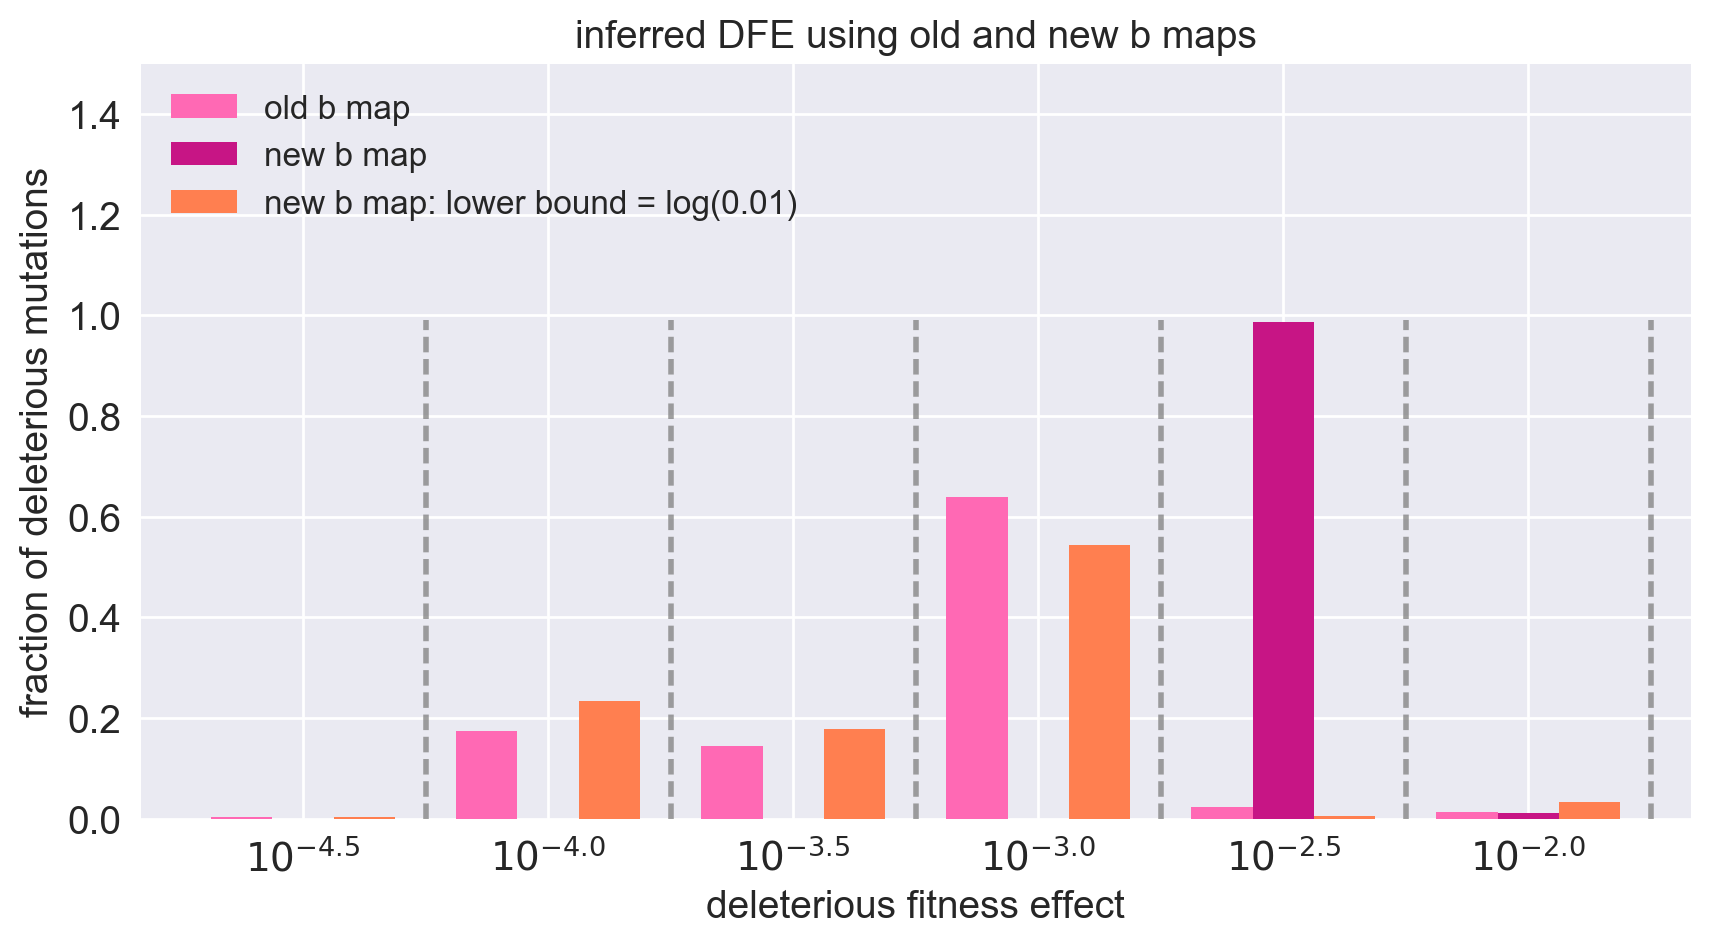

In [42]:
# get bar width and offset params
n = len(cs)
wth = 1.0 / (n+1)
shft = -0.5 * wth * n
idx = np.arange(cs[0].bsgrid)

plt.figure(figsize=(10,5))
for (i, cst) in enumerate(cs):
    cst.stat.calc_stats(cst) 
    p = cst.stat.upmf[0]
    x = idx+shft
    # plot DFE for a single run and then shift right for the next run
    plt.bar(x, p, wth, color=cols[i], label=lbls[i], align='edge')
    shft += wth

# separate DFE bins
for i in idx:
    plt.axvline(i+0.5, ymin=0, ymax=0.66, color='gray', ls='--', lw=2, alpha=0.75)
    
# label the plot
plt.title('inferred DFE using old and new b maps', fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel('fraction of deleterious mutations', fontsize=14)
plt.ylim(0, 1.5)
plt.xticks(idx, [r'$10^{%.1f}$' % x for x in np.linspace(-4.5, -2.0, 6)], fontsize=14)
plt.xlabel('deleterious fitness effect', fontsize=14)
plt.legend(prop=dict(size=12), ncol=1, loc='upper left')
plt.show()

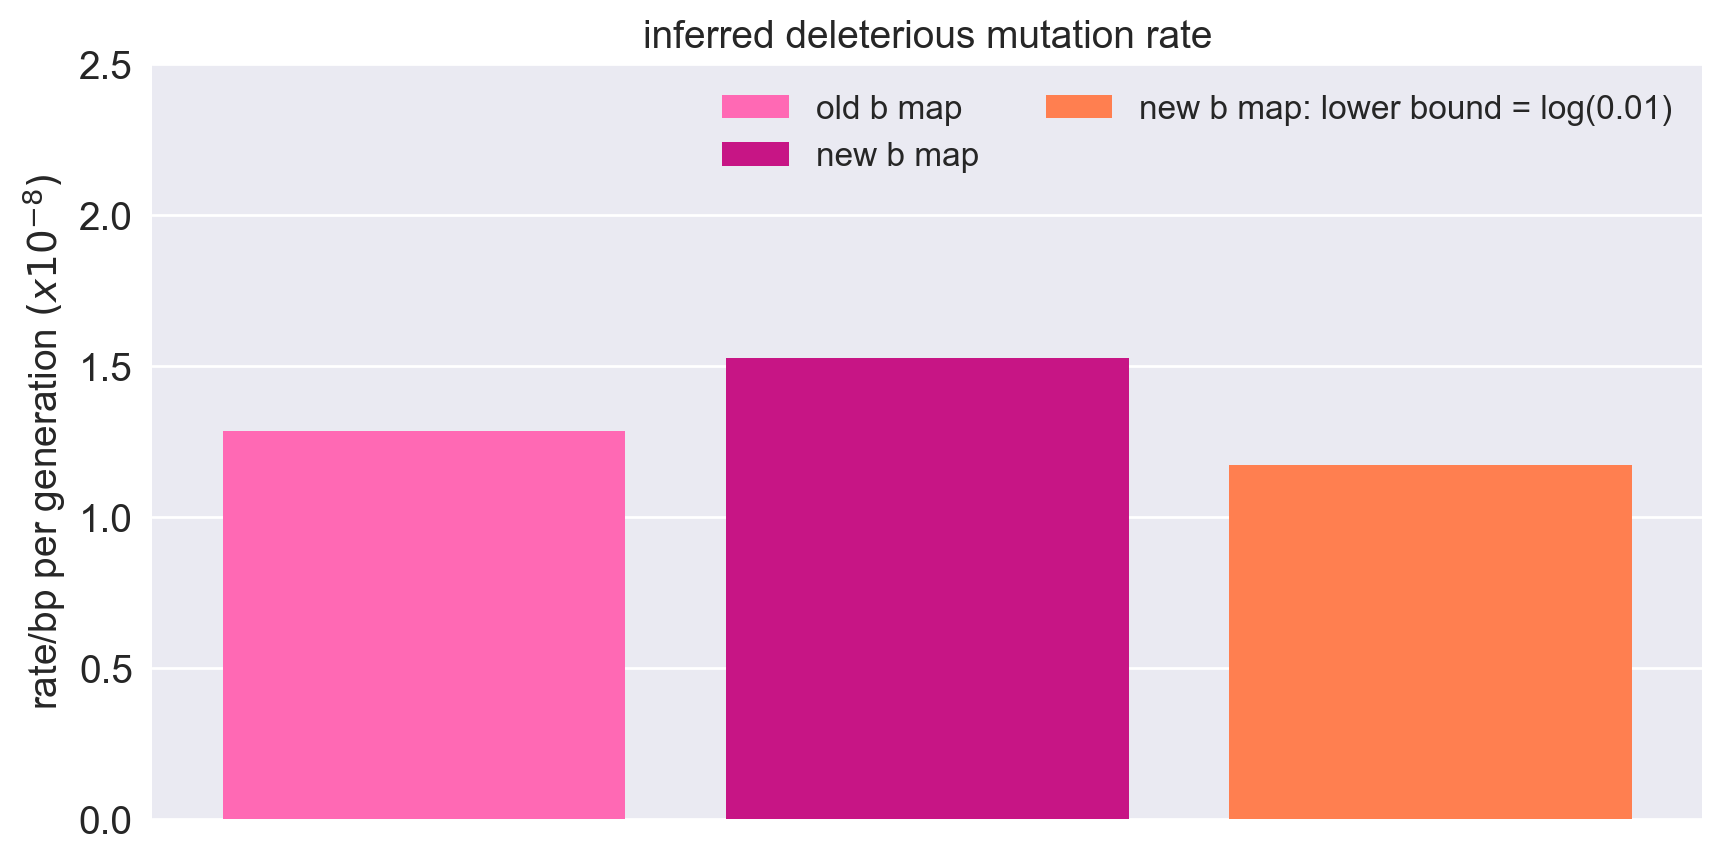

In [43]:
# plot u del
lg_col = np.ceil(len(cs) / 4.0).astype(int)
plt.figure(figsize=(10,5))
for (i, cst) in enumerate(cs):
    plt.bar(i, cst.stat.utot[0]*1e8, color=cols[i], label=lbls[i])

# label the plot
plt.title('inferred deleterious mutation rate', fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel('rate/bp per generation ' + r'$(x10^{-8})$', fontsize=14)
plt.ylim(0, 2.5)
plt.xticks([])
plt.legend(prop=dict(size=12), ncol=2)
plt.show()

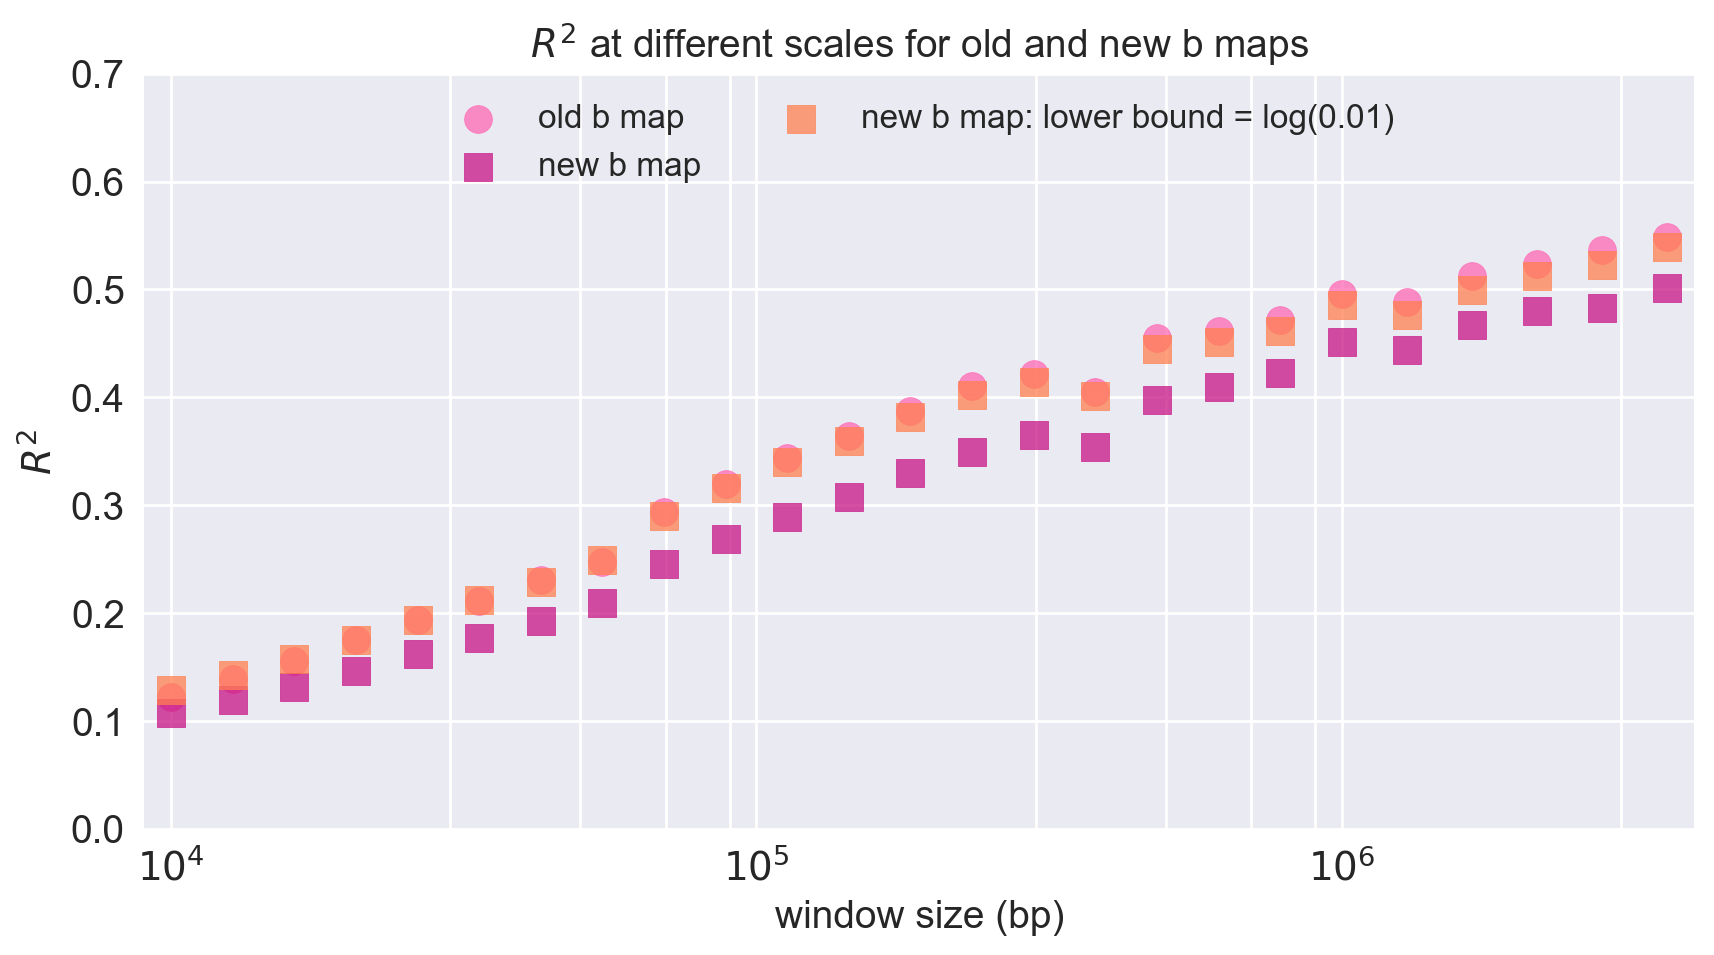

In [44]:
# plot variance explained
lg_col = np.ceil(len(cs) / 8.0).astype(int)
plt.figure(figsize=(10,5))
mb_vals = []
shps = ['o', 's', 's']
for (i, cst) in enumerate(cs):
#     dfmt = dict(marker=marks[i], color=cols[i], label=lbls[i], alpha=0.75)
    dfmt = dict(marker=shps[i], s=100, color=cols[i], label=lbls[i], alpha=0.75)

    w, r = np.array(cst.stat.rsq_values).T
    mb_vals.insert(0, (dfmt, r[w==1e6]))
    plt.scatter(w, r, **dfmt)

# label the plot
plt.title(r'$R^2$' + ' at different scales for old and new b maps', fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel(r'$R^2$', fontsize=14)
plt.ylim(0, 0.7)
plt.xscale('log')
xtck = np.concatenate([np.linspace(10**x, 10**(x+1), 10)[0:-1:2] for x in [4, 5, 6]])
plt.xticks(xtck, fontsize=14)
# plt.xticks(np.logspace(4, 7, 10), fontsize=14)
plt.xlabel('window size (bp)', fontsize=14)
plt.xlim(9e3, 4e6)
plt.legend(prop=dict(size=12), ncol=2, loc='upper center')
plt.show()

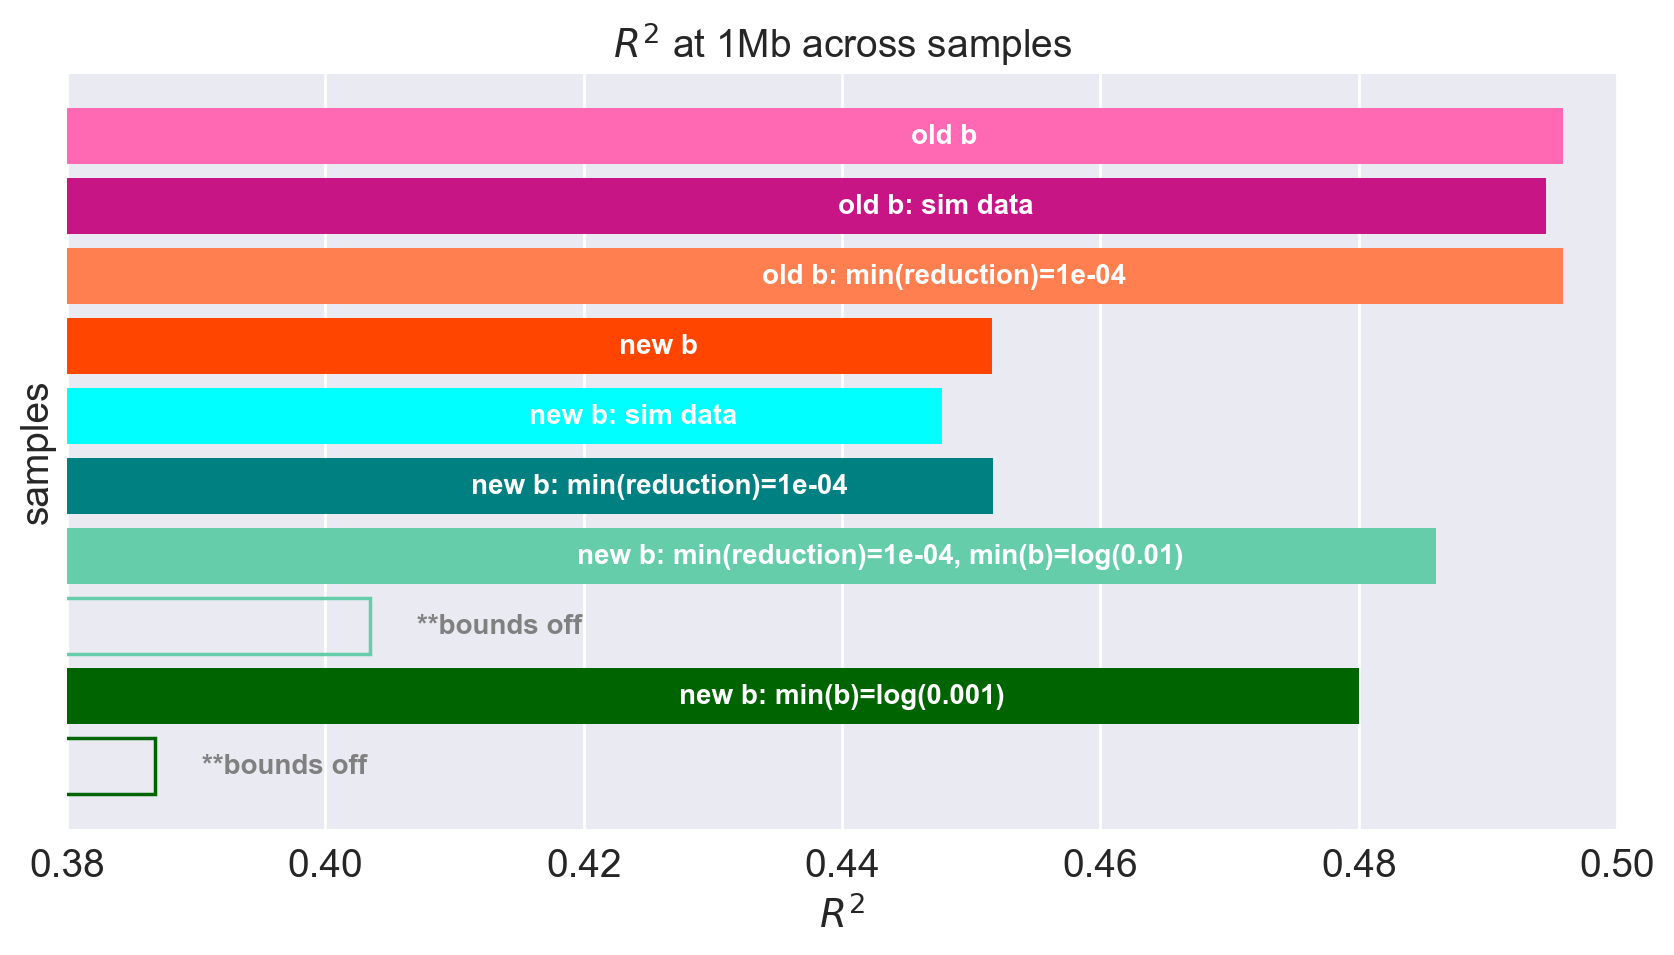

In [6]:
# plot variance explained at 1Mb in horizontal bars
plt.figure(figsize=(10,5))
i = 0 
for (df, r) in mb_vals:
    
    if i == 0:
        rx = 0.386796360873
        xmid = rx + 0.01
        plt.barh(i, rx, edgecolor=df['color'], color='None', lw=1.25)
        plt.text(x=xmid, y=i, s='**bounds off', ha='center', va='center', 
                 color='gray', fontweight='bold', fontsize=10)
        i += 1
        
    if i == 2:
        rx = 0.403483105929
        xmid = rx + 0.01
        plt.barh(i, rx, edgecolor=df['color'], color='None', lw=1.25)
        plt.text(x=xmid, y=i, s='**bounds off', ha='center', va='center', 
                 color='gray', fontweight='bold', fontsize=10)
        i += 1

    
    xmid = 0.4 + (r-0.4) * 0.5
    plt.barh(i, r, color=df['color'])
    plt.text(x=xmid, y=i, s=df['label'], ha='center', va='center', 
             color='white', fontweight='bold', fontsize=10)
    i += 1
    
    
    

plt.title(r'$R^2$' + ' at 1Mb across samples', fontsize=14)
plt.yticks([])
plt.ylabel('samples', fontsize=14)
plt.xticks(fontsize=14)
plt.xlabel(r'$R^2$', fontsize=14)
plt.xlim(0.38, 0.5)
plt.show()
    

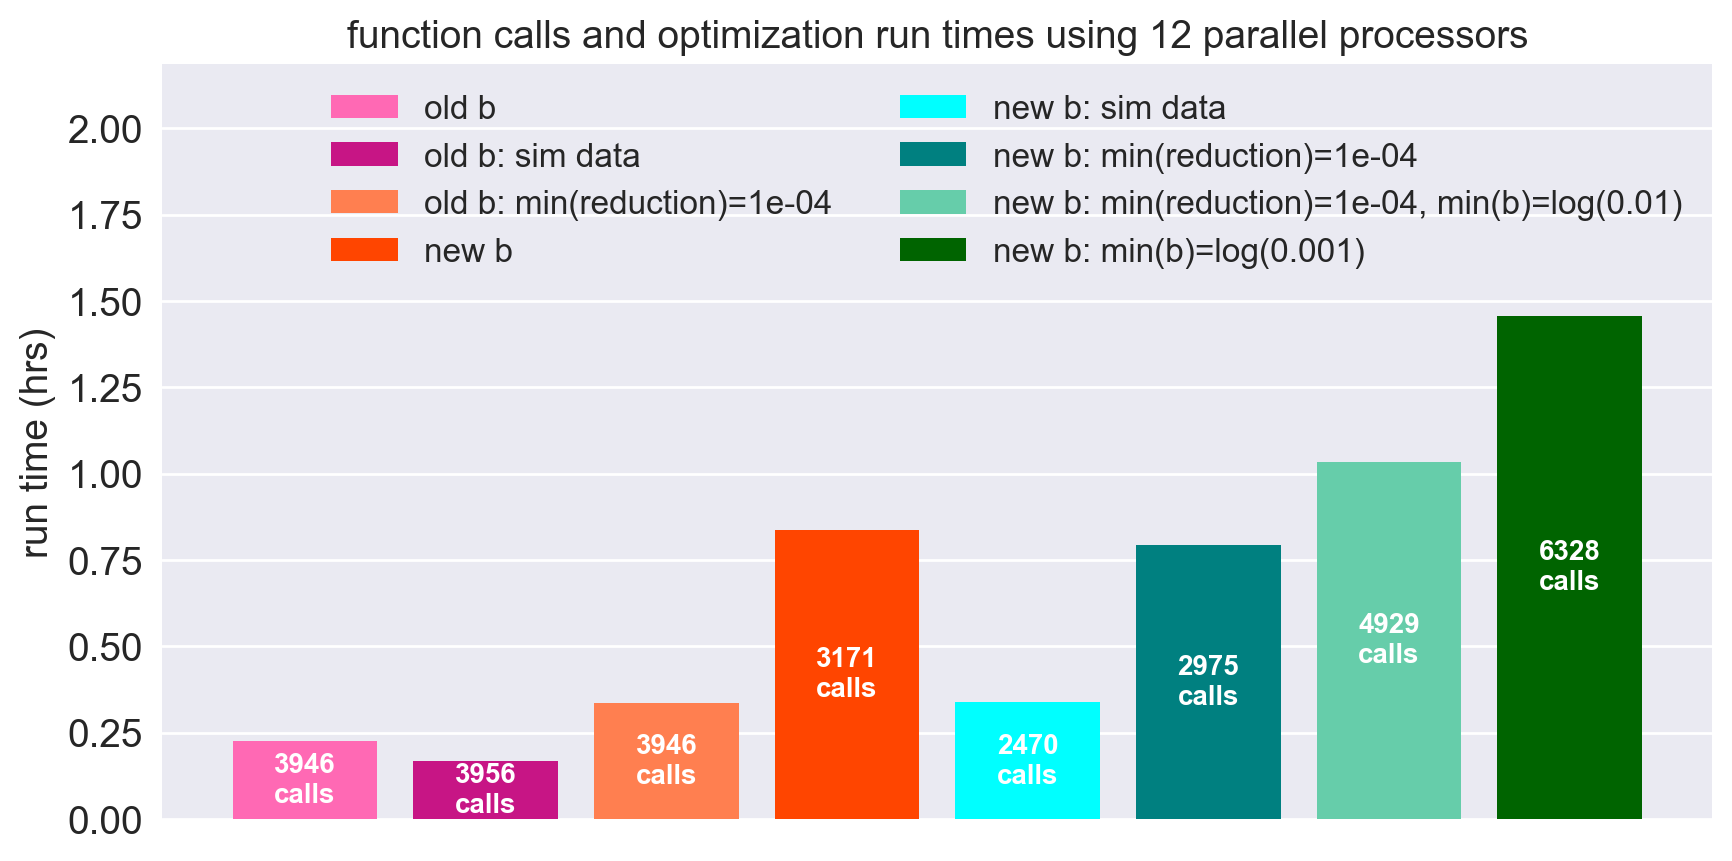

In [7]:
# optimization stats
plt.figure(figsize=(10,5))
hmax = -1
for (i, cst) in enumerate(cs):
#     fcalls = cst.stat.function_calls
#     runtime = '{:.2f}h'.format(cst.stat.total_time)
#     plt.bar(i, fcalls, 0.8, color=cols[i], label=lbls[i])
    fun_calls = '{}\ncalls'.format(cst.stat.function_calls)
    runtime = cst.stat.total_time
    plt.bar(i, runtime, 0.8, color=cols[i], label=lbls[i])

#     plt.text(x=i, y=0.5*fcalls, s=runtime, ha='center', va='center', 
#              color='white', fontweight='bold', fontsize=10)
#     hmax = max(hmax, fcalls)
    plt.text(x=i, y=0.5*runtime, s=fun_calls, ha='center', va='center', 
             color='white', fontweight='bold', fontsize=10)
    hmax = max(hmax, runtime)
    
# label the plot
plt.title('function calls and optimization run times using 12 parallel processors', fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel('run time (hrs)', fontsize=14)
plt.ylim(0, 1.5 * hmax)
plt.xticks([])
plt.legend(prop=dict(size=12), ncol=2)
plt.show()

In [8]:
# set some constants

# indices for select runs
i_old = 0
i_new = 3
i_newbound = i_new+3

# fix num_cores to 1 for all arrays so inputs are not split
for cst in cs:
    cst.vars.num_cores = 1

# set bs min corresponding to 100 bins big B maps
min_bs = np.log(0.01)
euler = np.exp(1)
pred_arrs = []

In [9]:
# data arrays (old)
cs_old = cs[i_old]
n1, u1, b1, d1, s1, p1 = load_saved(cs_old, new=0, poly=1)
ipt1 = prepare_inputs(cst=cs_old, new=False)

In [10]:
# predictions from old b map
dv = d1[d1>0]
poly = p1[d1>0]
# pi = ipt1.het / (ipt1.hom+ipt1.het)
pr_old = predicted_pi(cs_old.params, cs_old, ipt1.u, ipt1.bs, None)
pred_arrs.append((pr_old, dv, poly))

In [11]:
# data arrays (new)
cs_new = cs[i_new]
cs_newbound = cs[i_newbound]
n2, u2, b2, d2, s2, p2 = load_saved(cs_new, new=1, poly=1)
# inputs to new b map run with no bounds
ipt2 = prepare_inputs(cst=cs_new, new=True)
# constant inputs for new b runs
dv = d2[d2>0]
poly = p2[d2>0]
pi = ipt2.het / (ipt2.hom+ipt2.het)

In [12]:
# prediction for unbounded new b map
pr_newnobound = predicted_pi(cs_new.params, cs_new, ipt2.u, ipt2.bs, None)
# pred_arrs.append((pr_newnobound, dv, ispoly))
pred_arrs.append((pr_newnobound, dv, poly))

In [13]:
# prediction for unbounded new b map using params from truncated new b map run
pr_newnobound_force = predicted_pi(cs_newbound.params, cs_new, ipt2.u, ipt2.bs, None)
# pred_arrs.append((pr_newnobound_force, dv, ispoly))
pred_arrs.append((pr_newnobound_force, dv, poly))

In [14]:
# inputs to new b map run with truncated b and bounded red
ipt4 = prepare_inputs(cst=cs_newbound, new=True)
# prediction for bounded new b map 
pr_newbound = predicted_pi(cs_newbound.params, cs_newbound, ipt4.u, ipt4.bs, None)
# pred_arrs.append((pr_newbound, dv, ispoly))
pred_arrs.append((pr_newbound, dv, poly))

In [15]:
# count up neutral and neutral poly in prediction bins across runs
histos = []
for (i, row) in enumerate(pred_arrs):
    pr, dv, ply = row
    pr_bins = np.linspace(pr.min(), pr.max(), 1000)
    pr_cnt = np.histogram(pr, pr_bins, weights=dv)[0]
    pr_poly_cnt = np.histogram(pr, pr_bins, weights=ply)[0]
    histos.append((pr_bins, pr_cnt, pr_poly_cnt))

In [16]:
# plot neutral site counts per prediction bin across inf runs
plt.figure(figsize=(10,5))
labels = 'old,new unbounded,new unbounded force bounded params,new bounded'.split(',')
for (i, row) in enumerate(histos):
    pr_bins, pr_cnt = row[0], row[1]
    plt.step(pr_bins[1:], pr_cnt, label=labels[i], color=cols[i], lw=1.0, alpha=0.8)

plt.title('total neutral sites per prediction value bins', fontsize=14)
plt.ylabel('neutral site count', fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('prediction bins')
plt.xticks(fontsize=14)
plt.xlim(-0.0001, 0.0025)
plt.legend(prop=dict(size=12), loc='best')
# plt.show()

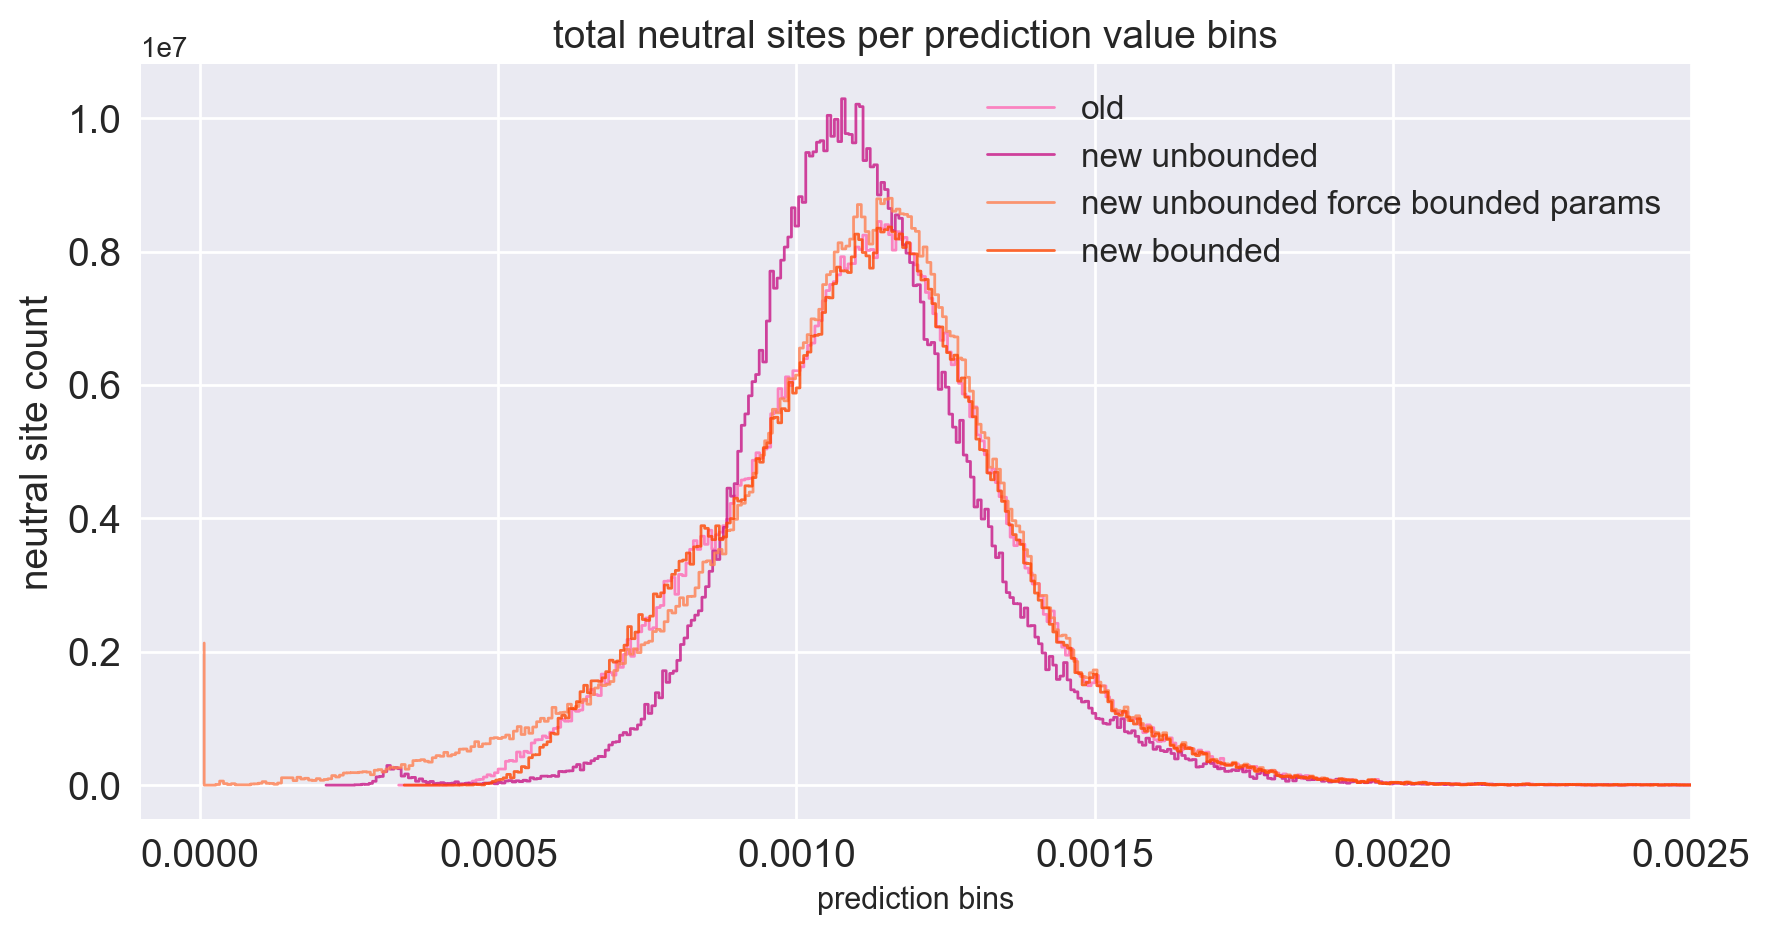

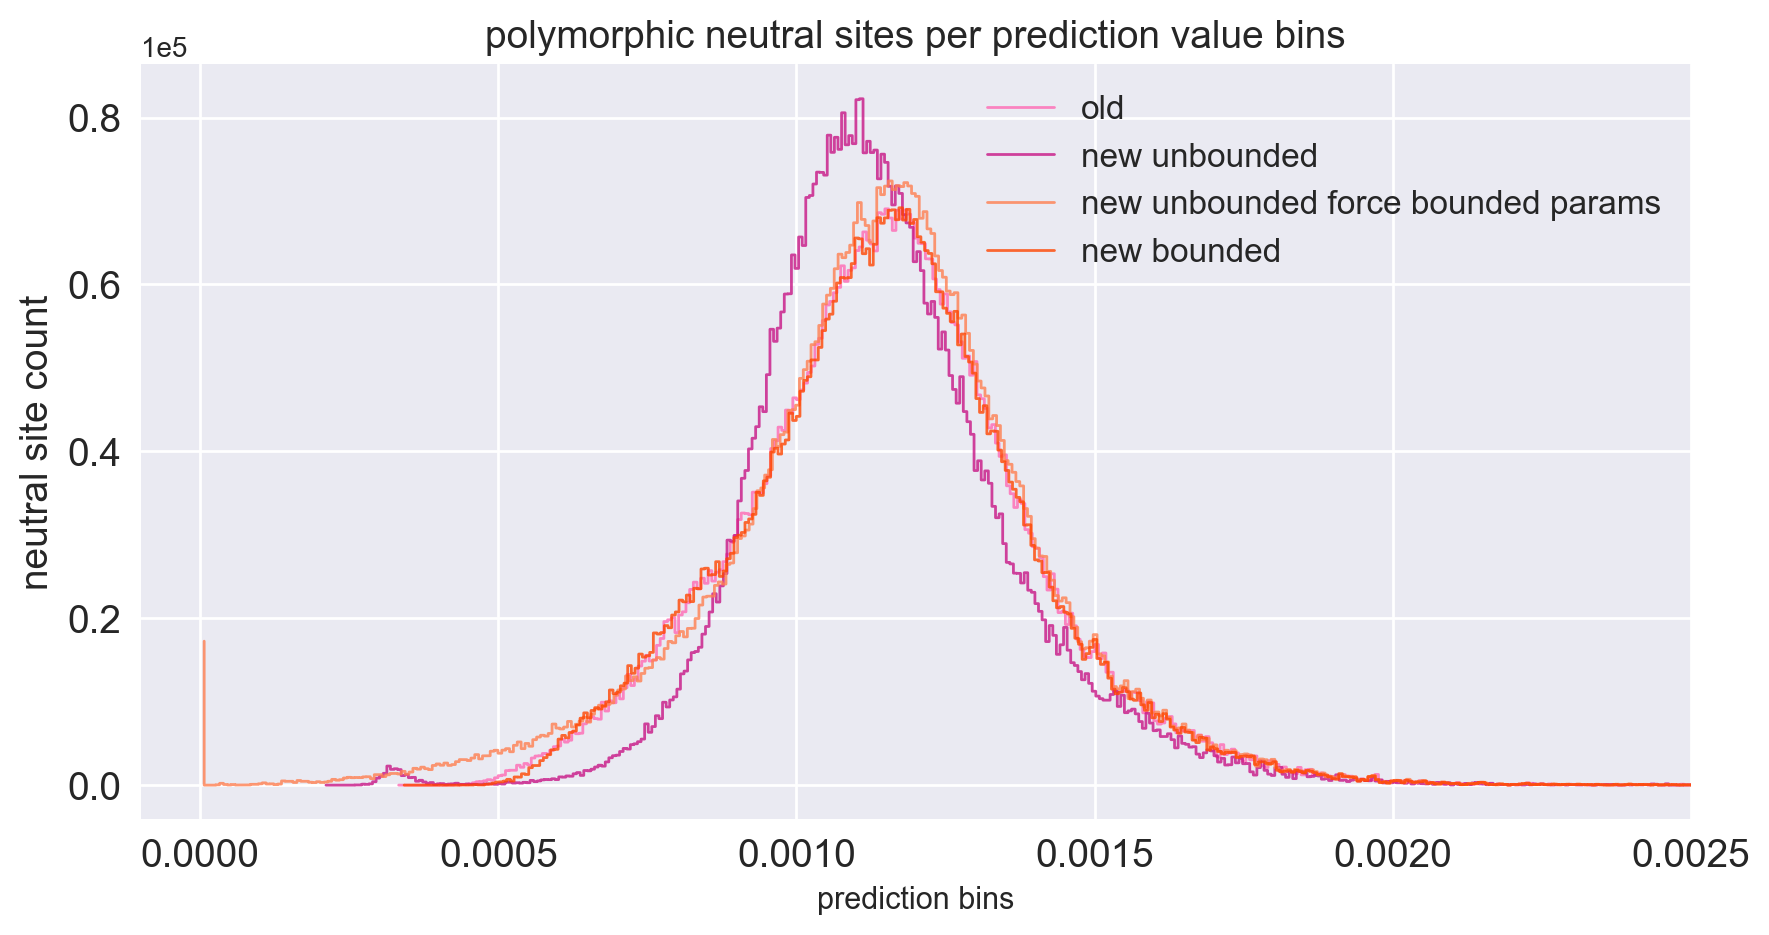

In [17]:
# plot polymorphic neutral site counts per prediction bin across inf runs
plt.figure(figsize=(10,5))
labels = 'old,new unbounded,new unbounded force bounded params,new bounded'.split(',')
for (i, row) in enumerate(histos):
    pr_bins, pr_poly = row[0], row[2]
    plt.step(pr_bins[1:], pr_poly, label=labels[i], color=cols[i], lw=1.0, alpha=0.8)

plt.title('polymorphic neutral sites per prediction value bins', fontsize=14)
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.ylabel('neutral site count', fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('prediction bins')
plt.xticks(fontsize=14)
plt.xlim(-0.0001, 0.0025)
plt.legend(prop=dict(size=12), loc='best')

plt.show()

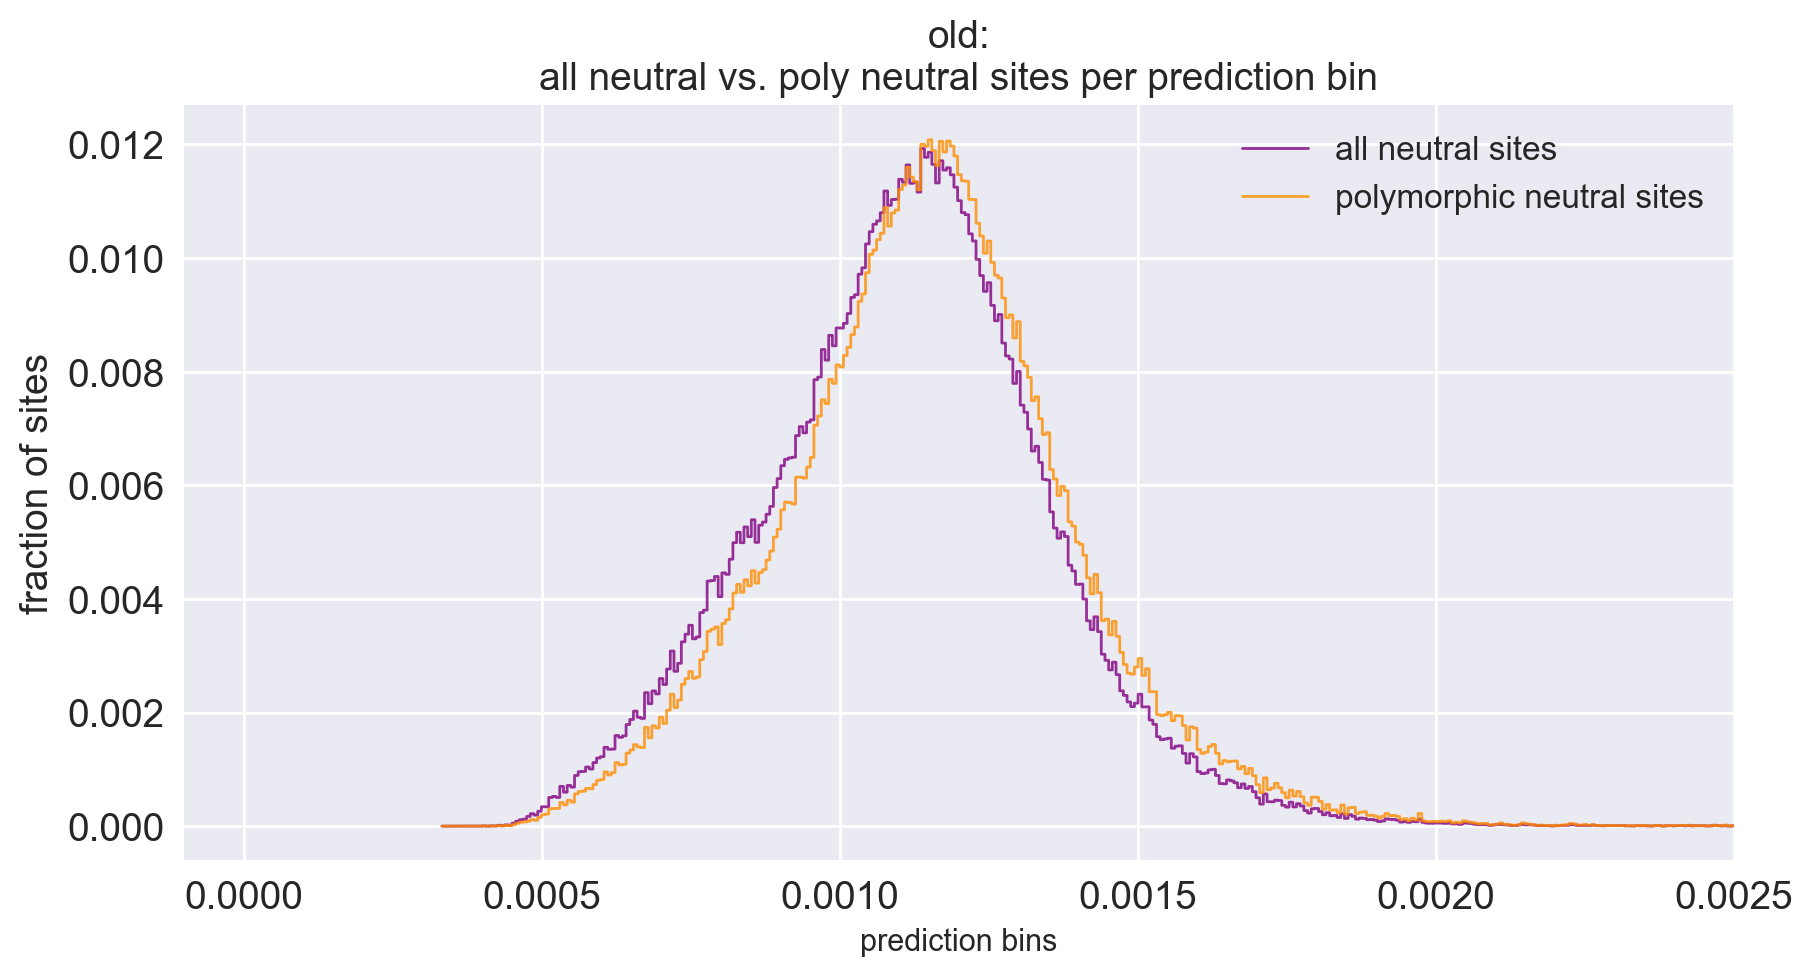

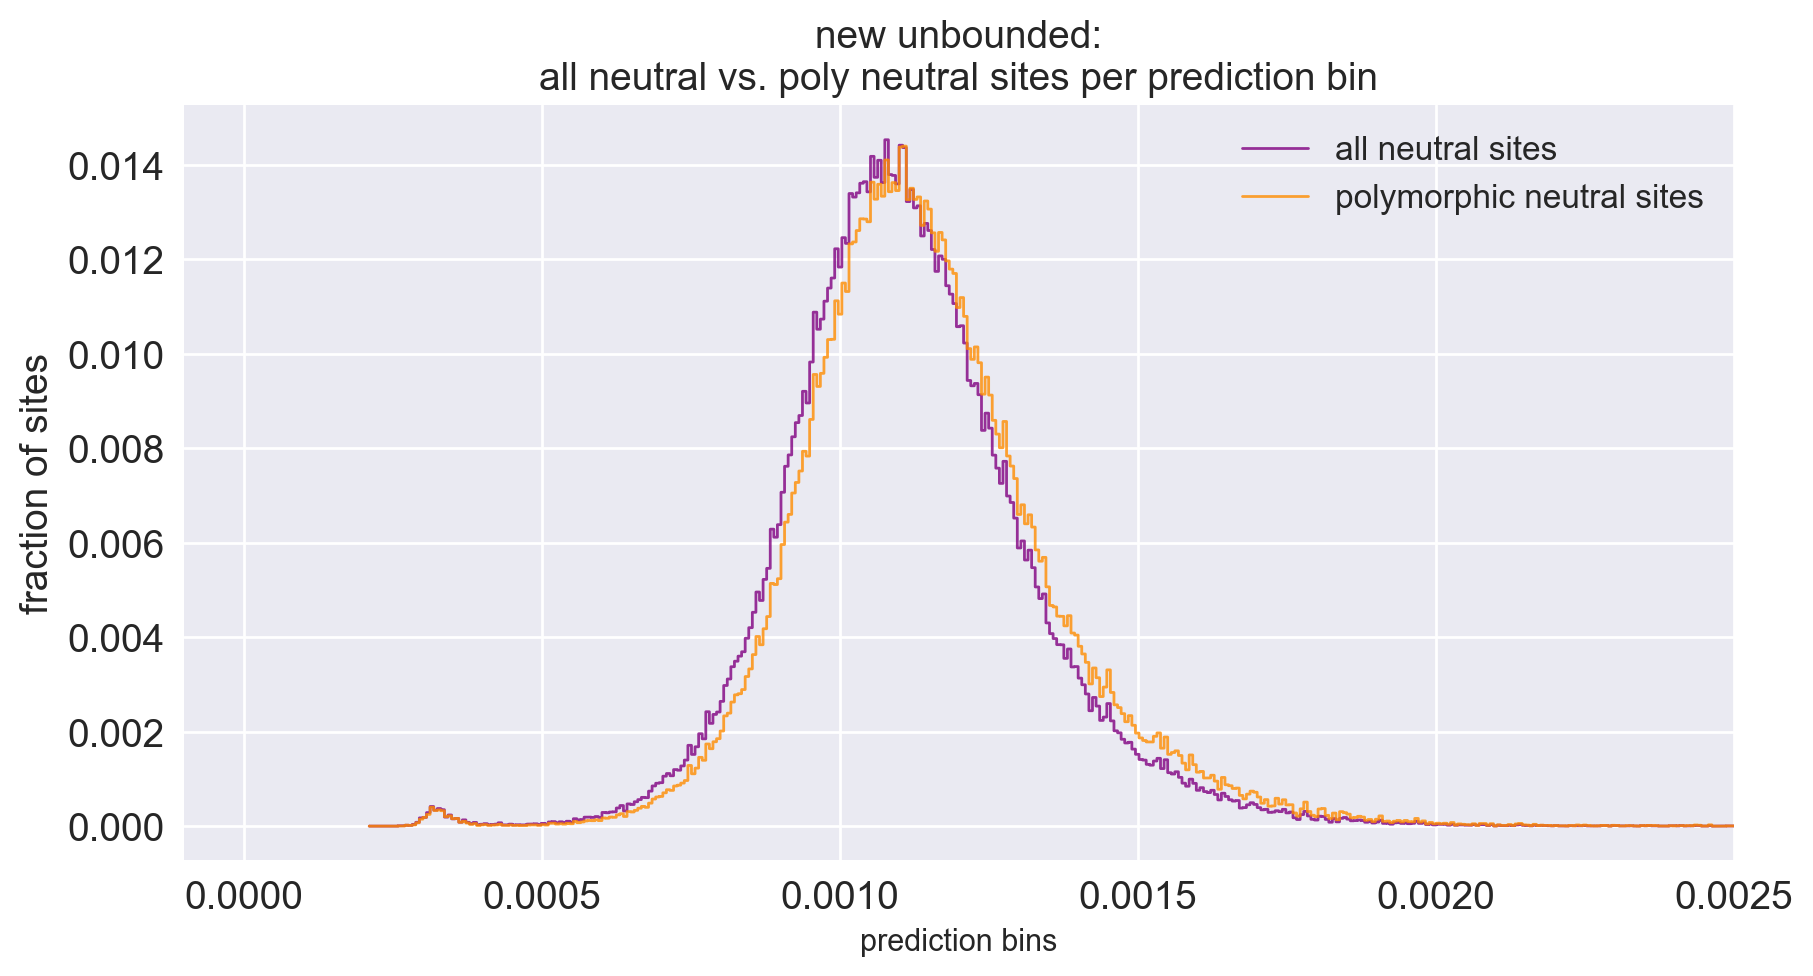

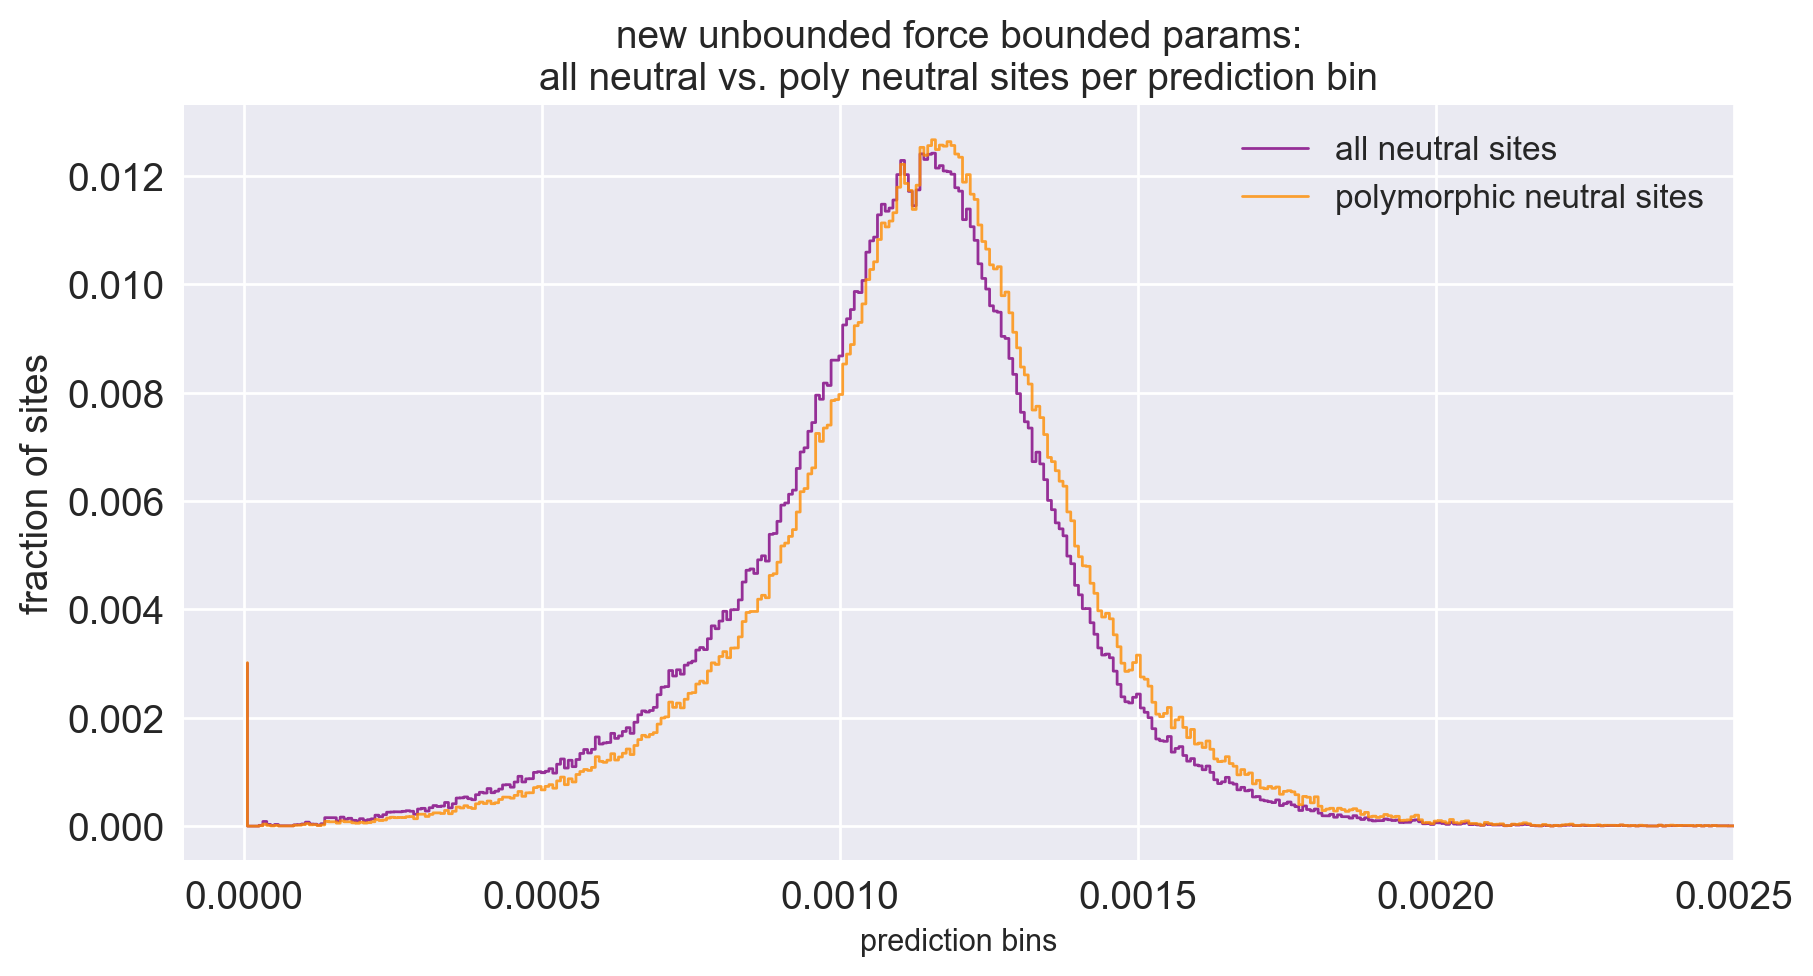

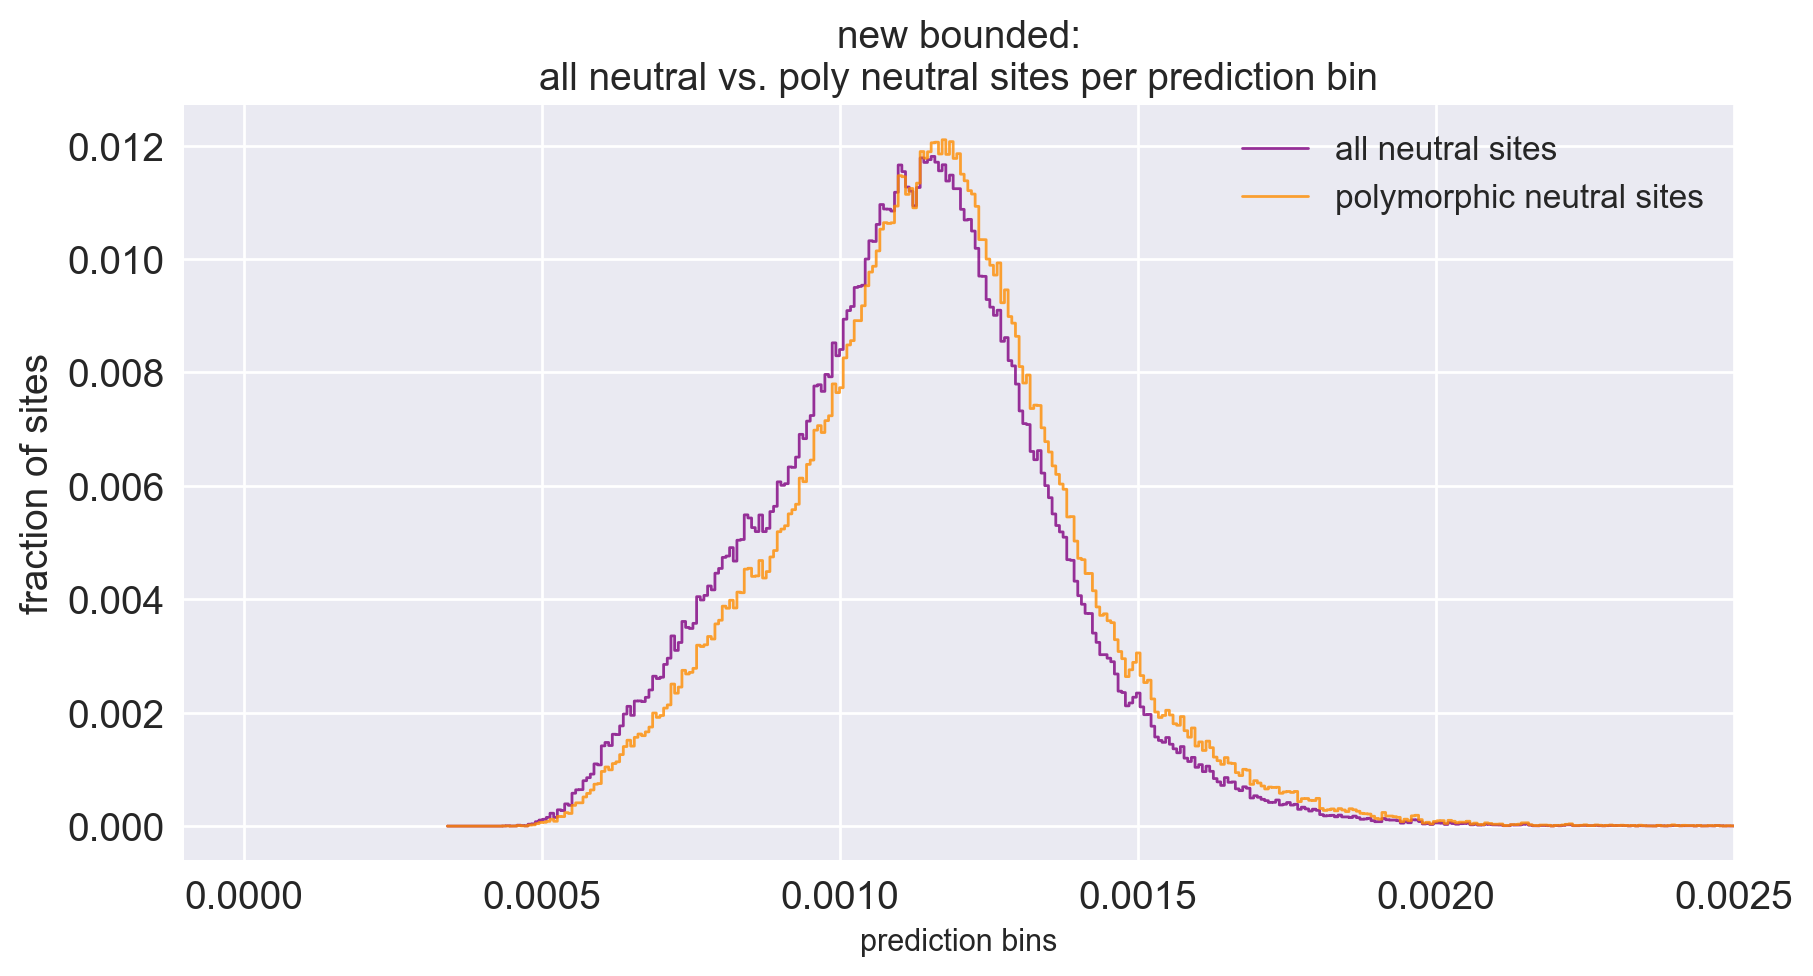

In [19]:
# compare fraction of all neutral vs. poly neutral in prediction bins for each case
labels = 'old,new unbounded,new unbounded force bounded params,new bounded'.split(',')
for (i, row) in enumerate(histos):
    # normalize neutral all & neutral poly counts
    pr_bins, pr_cnt, pr_poly = row
    pr_cnt /= np.sum(pr_cnt, dtype='f8')
    pr_poly /= np.sum(pr_poly, dtype='f8')
    # make a new figure for each run
    plt.figure(figsize=(10,5))
    plt.step(pr_bins[1:], pr_cnt, label='all neutral sites', color='purple', lw=1.0, alpha=0.8)
    plt.step(pr_bins[1:], pr_poly, label='polymorphic neutral sites', color='darkorange', lw=1.0, alpha=0.8)

    plt.title('{}:\nall neutral vs. poly neutral sites per prediction bin'.format(labels[i]), fontsize=14)
    plt.ylabel('fraction of sites', fontsize=14)
    plt.yticks(fontsize=14)
    plt.xlabel('prediction bins')
    plt.xticks(fontsize=14)
    plt.xlim(-0.0001, 0.0025)
    plt.legend(prop=dict(size=12), loc='best')

# show group of figures
plt.show()

In [228]:
# bin neutral sites by prediction error
err = calculate_error(pr, pi, rel=1, fabs=1)
# getting sort errors, neutral site counts with err sorting index
idx = err.argsort()
# err, pr, pi, dv = err[idx], pr[idx], pi[idx], dv[idx]
err, dv = err[idx], dv[idx]

# divide segments evenly among n bins
nbins = 1000
ij = split_index(len(err), nbins)
srt = np.zeros(shape=(2, nbins))
# take mean error and neutral site sum for each bin
for (col, (i, j)) in enumerate(ij):
    srt[0, col] = np.mean(err[i:j])
    srt[1, col] = np.sum(dv[i:j])


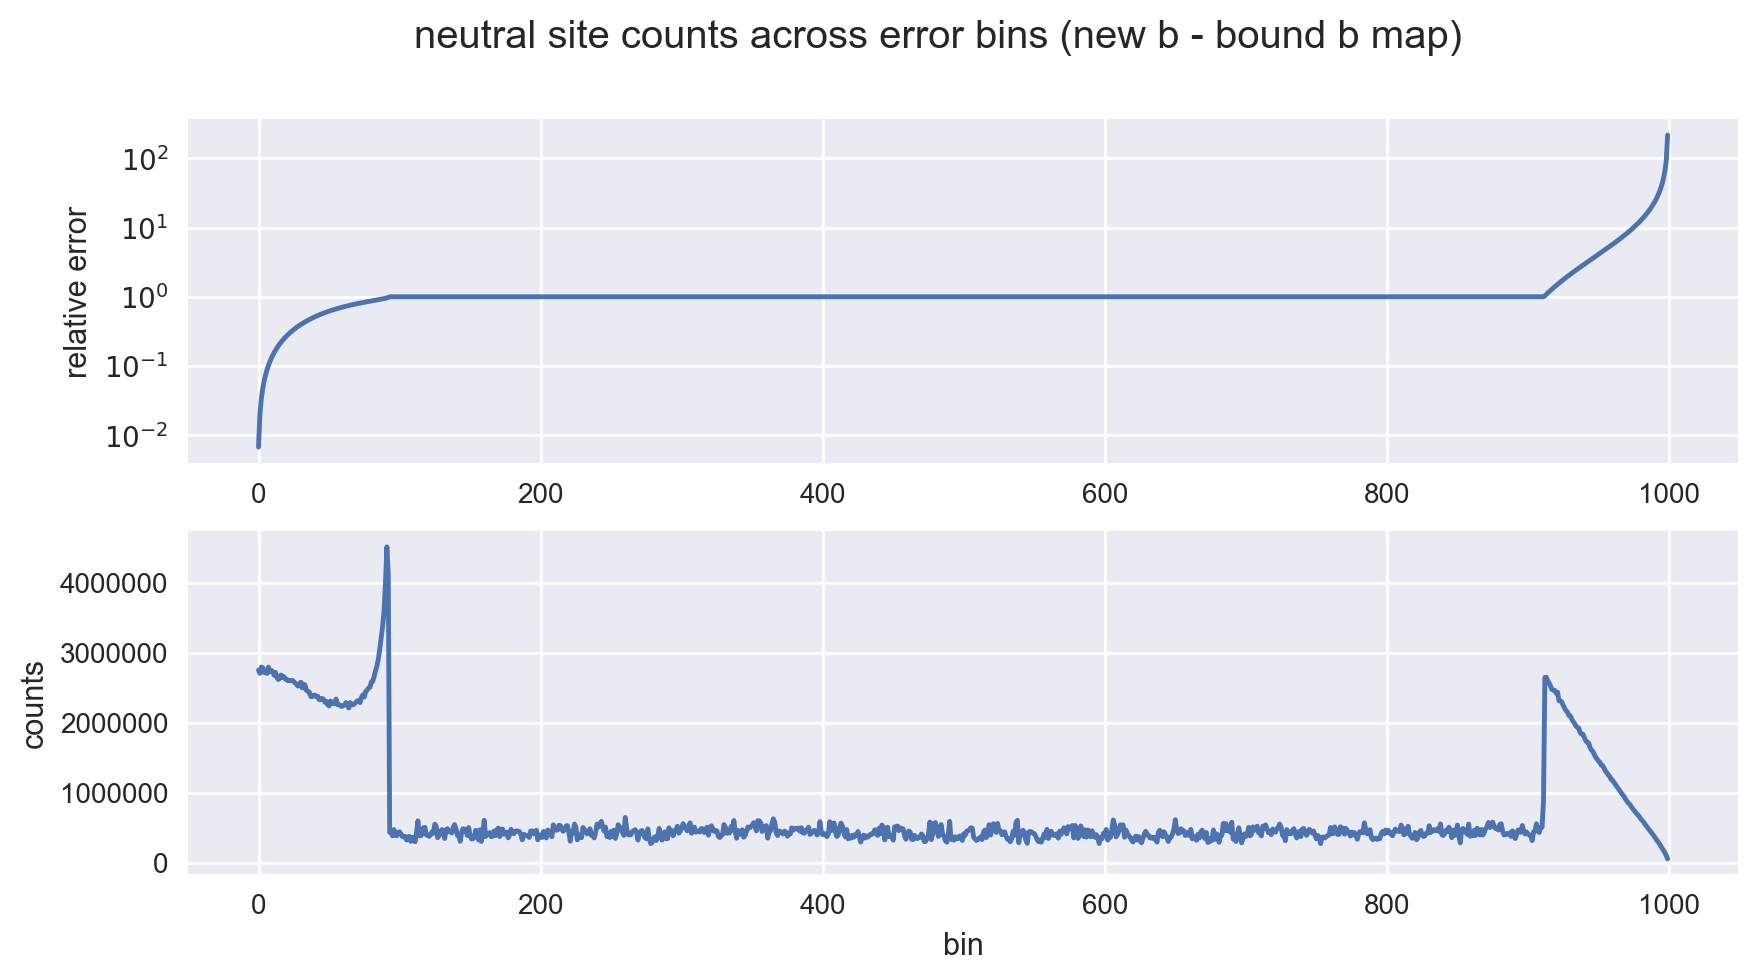

In [230]:
# 
plt.figure(figsize=(10,5))
# plt.suptitle('neutral site counts across error bins (new b)')
# plt.suptitle('neutral site counts across error bins (new b - force params from bounded b map)')
plt.suptitle('neutral site counts across error bins (new b - bound b map)')

plt.subplot(211)
plt.plot(srt[0], label='observed - predicted pi')
# plt.ylabel('observed - predicted pi')
# plt.ylabel('additive error')
plt.ylabel('relative error')

plt.yscale('log')
plt.subplot(212)
plt.plot(srt[1])
# plt.plot(srt[2], label='mean pi')
plt.ylabel('counts')
# plt.yscale('log')
plt.xlabel('bin')
# plt.legend()
plt.show()

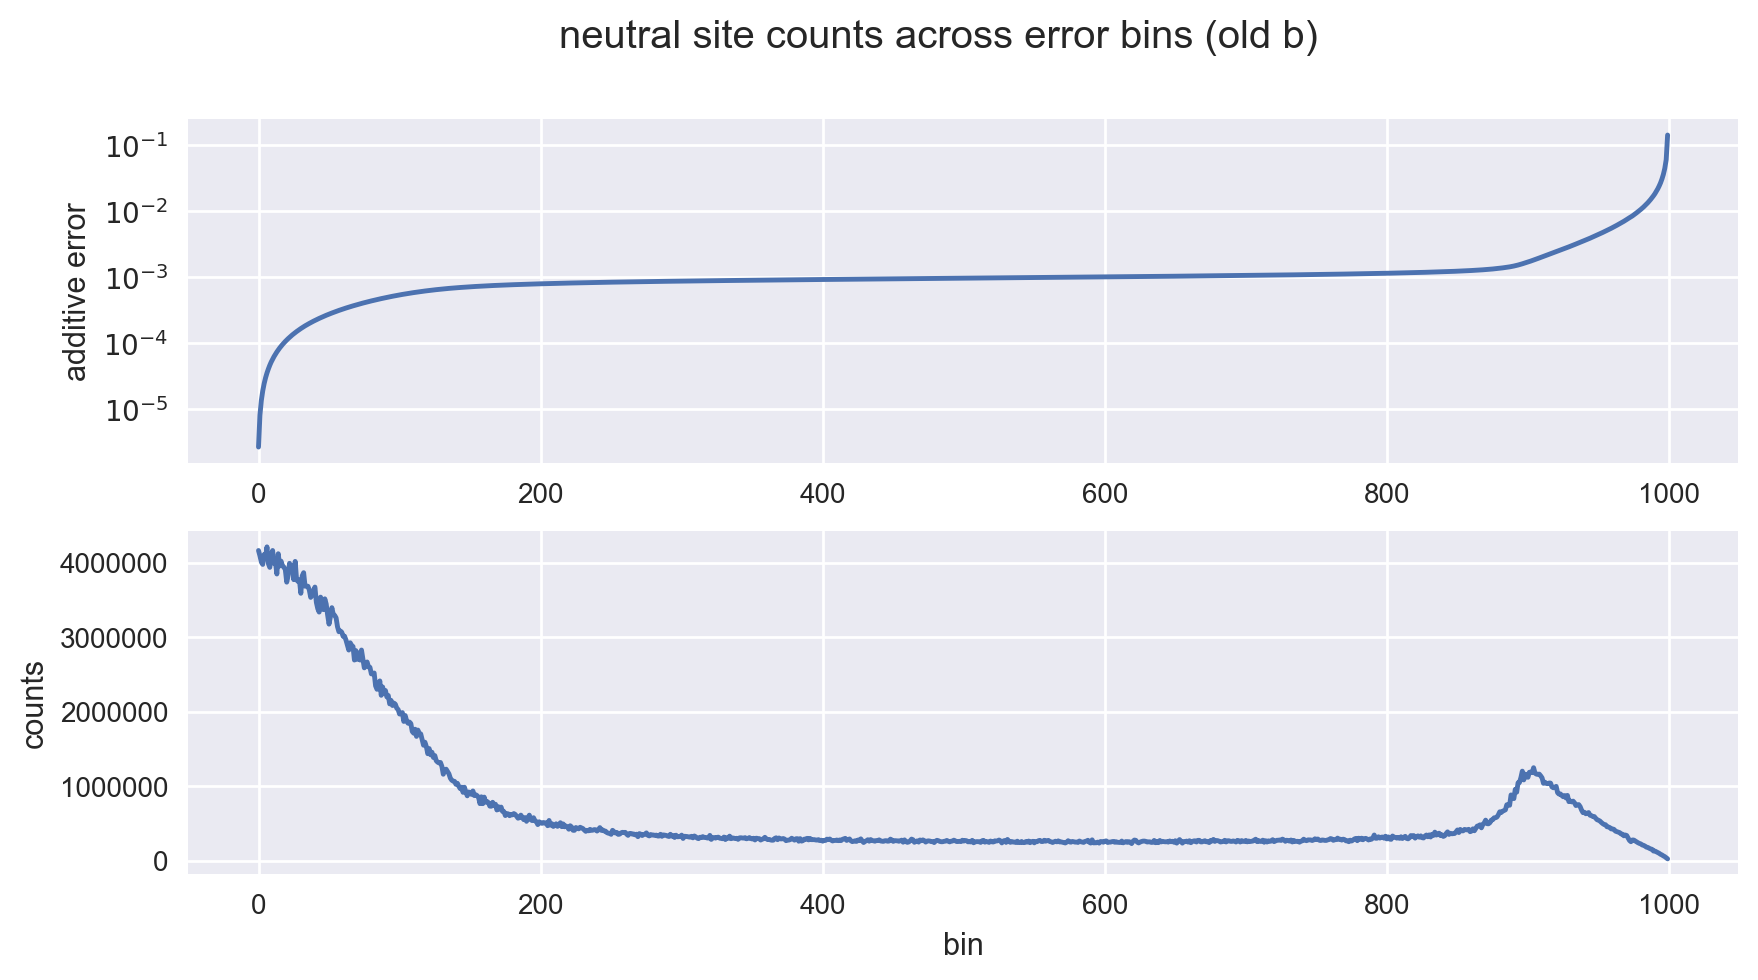

In [194]:
#
plt.figure(figsize=(10,5))
plt.suptitle('neutral site counts across error bins (old b)')
plt.subplot(211)
plt.plot(srt[0], label='observed - predicted pi')
plt.ylabel('additive error')
# plt.ylabel('relative error')
plt.yscale('log')
plt.subplot(212)
plt.plot(srt[1])
# plt.plot(srt[2], label='mean pi')
plt.ylabel('counts')
# plt.yscale('log')
plt.xlabel('bin')
# plt.legend()
plt.show()

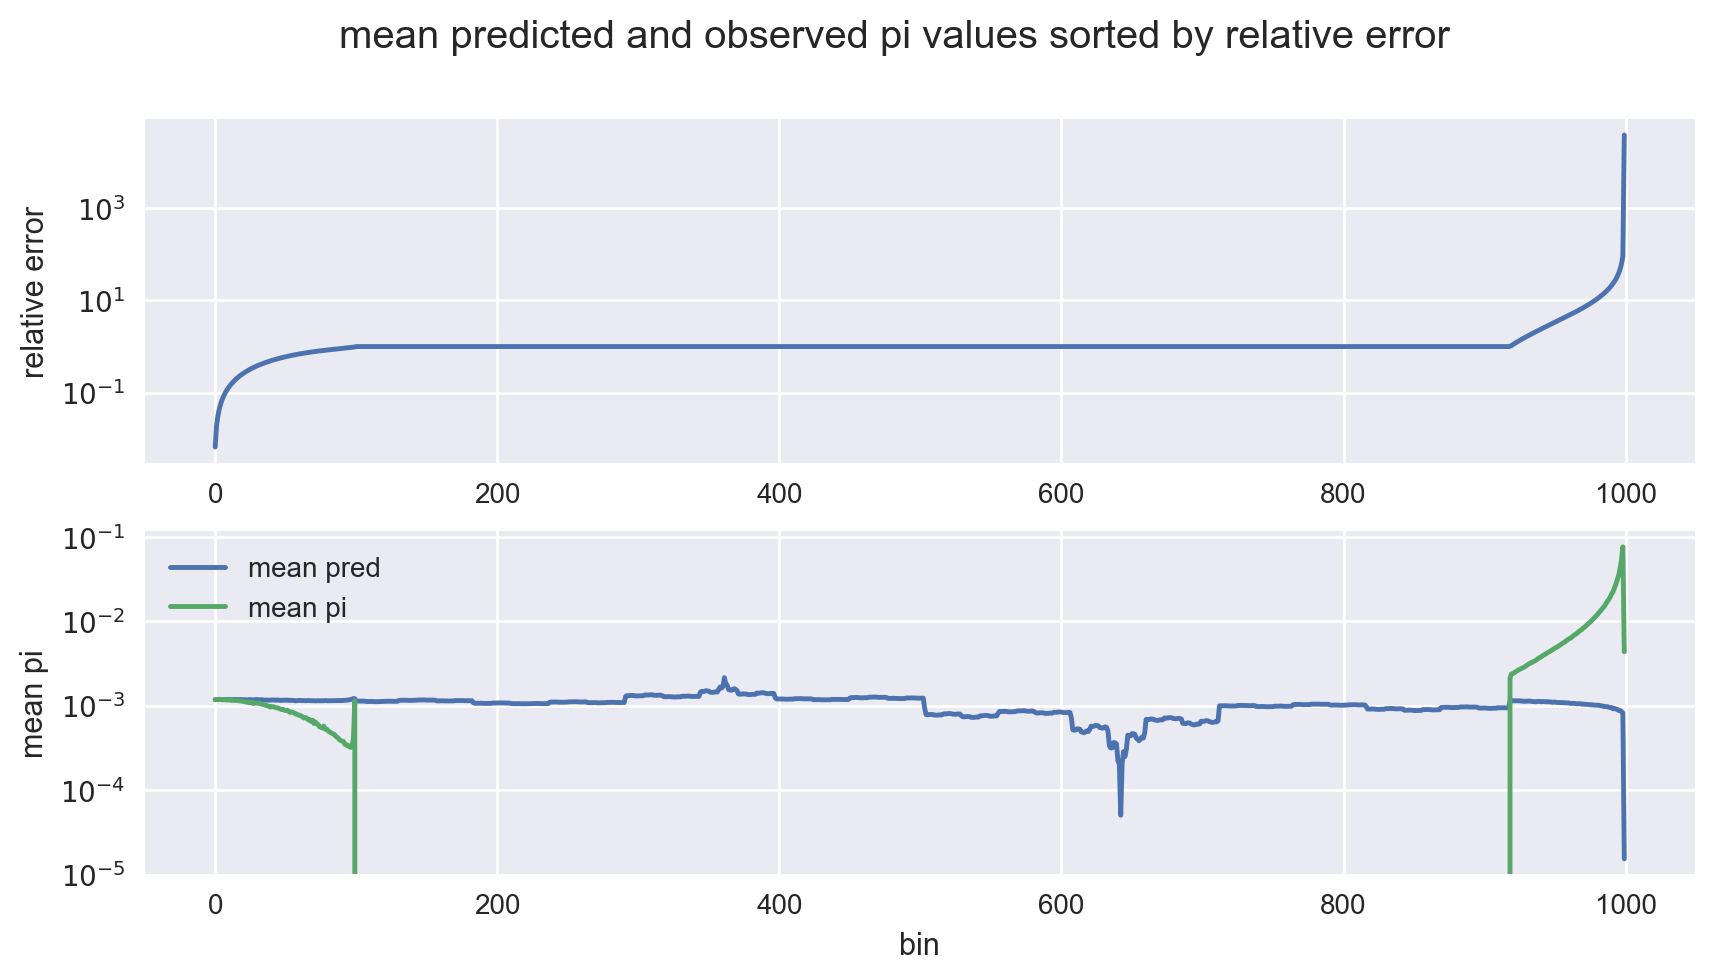

In [82]:
#
srt = np.zeros(shape=(3, nbins))
col = 0
for (i, j) in ij:
    srt[0, col] = np.average(err[i:j], weights=dv[i:j])
    srt[1, col] = np.average(pr[i:j], weights=dv[i:j])
    srt[2, col] = np.average(pi[i:j], weights=dv[i:j])
    col += 1

plt.figure(figsize=(10,5))
plt.suptitle('mean predicted and observed pi values sorted by relative error')
plt.subplot(211)
plt.plot(srt[0], label='err')
plt.ylabel('relative error')
plt.yscale('log')
plt.subplot(212)
plt.plot(srt[1], label='mean pred')
plt.plot(srt[2], label='mean pi')
plt.ylabel('mean pi')
plt.yscale('log')
plt.xlabel('bin')
plt.legend()
plt.show()

In [54]:
srt[2].min()

0.0

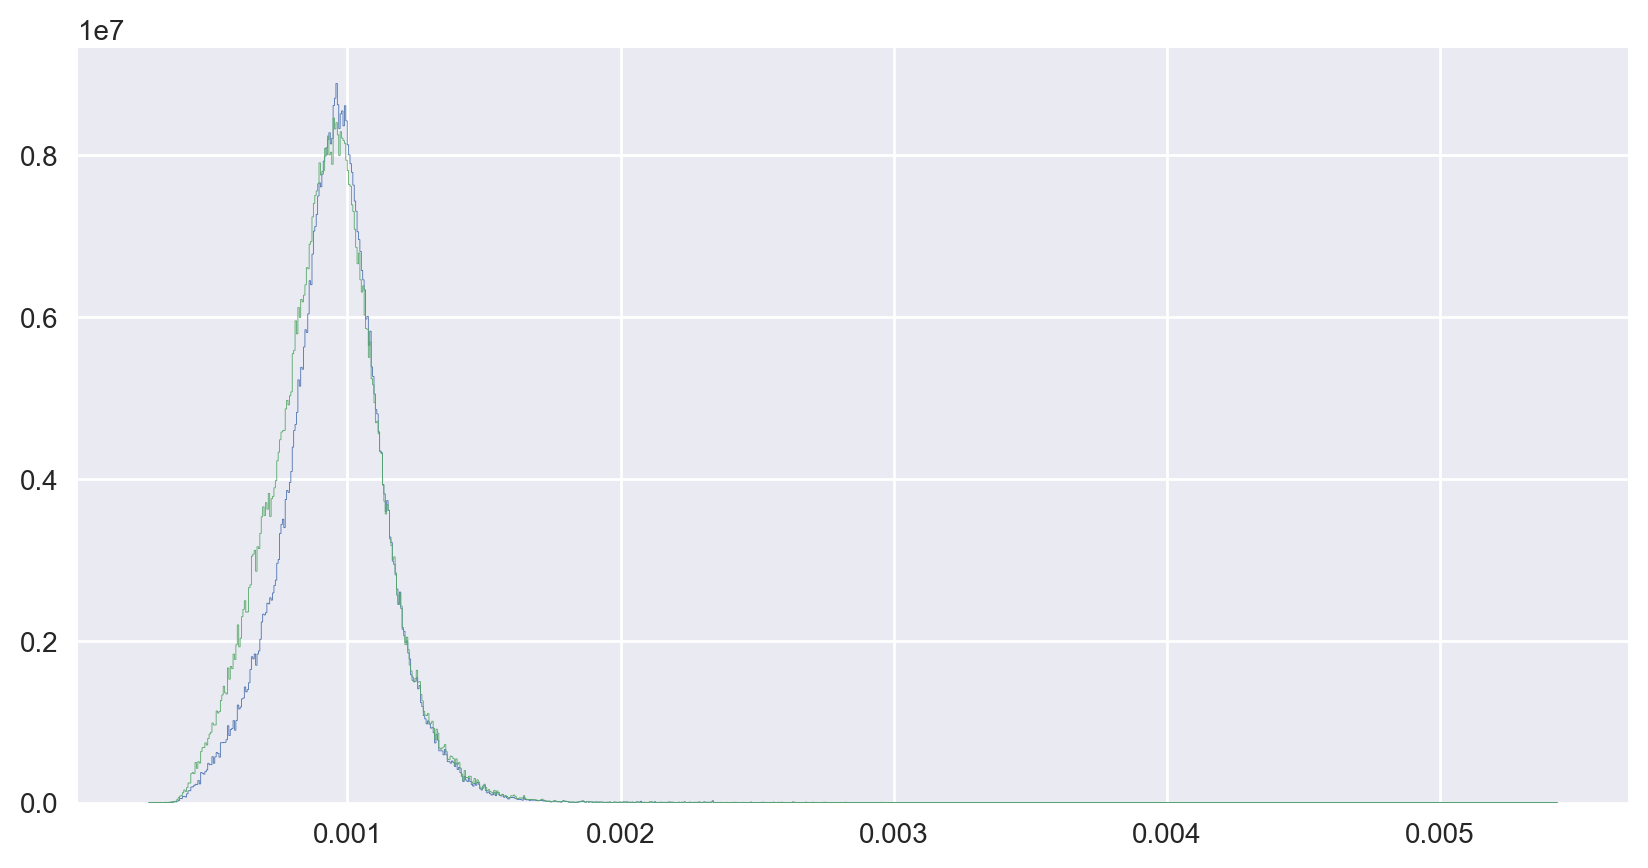

In [32]:
# cn1, bn1 = np.histogram(pr1, bins=1000, weights=err)
plt.figure(figsize=(10,5))
plt.hist(pr1, bins=1000, histtype='step', weights=err*d1[d1>0])
plt.hist(pr1, bins=1000, histtype='step', weights=d1[d1>0])

plt.show()

In [57]:
# # additional params for new maps
# wt3 = np.power(10, cs_new.params[:6]) / cs_new.fixed.u_fix
# pb3 = np.dot(b2[m2], wt3)
# wt4 = np.power(10, cs[3].params[:6]) / cs[3].fixed.u_fix
# pb4 = np.dot(b2[m2], wt4)

---
# checking estimated neutral u values for old/new

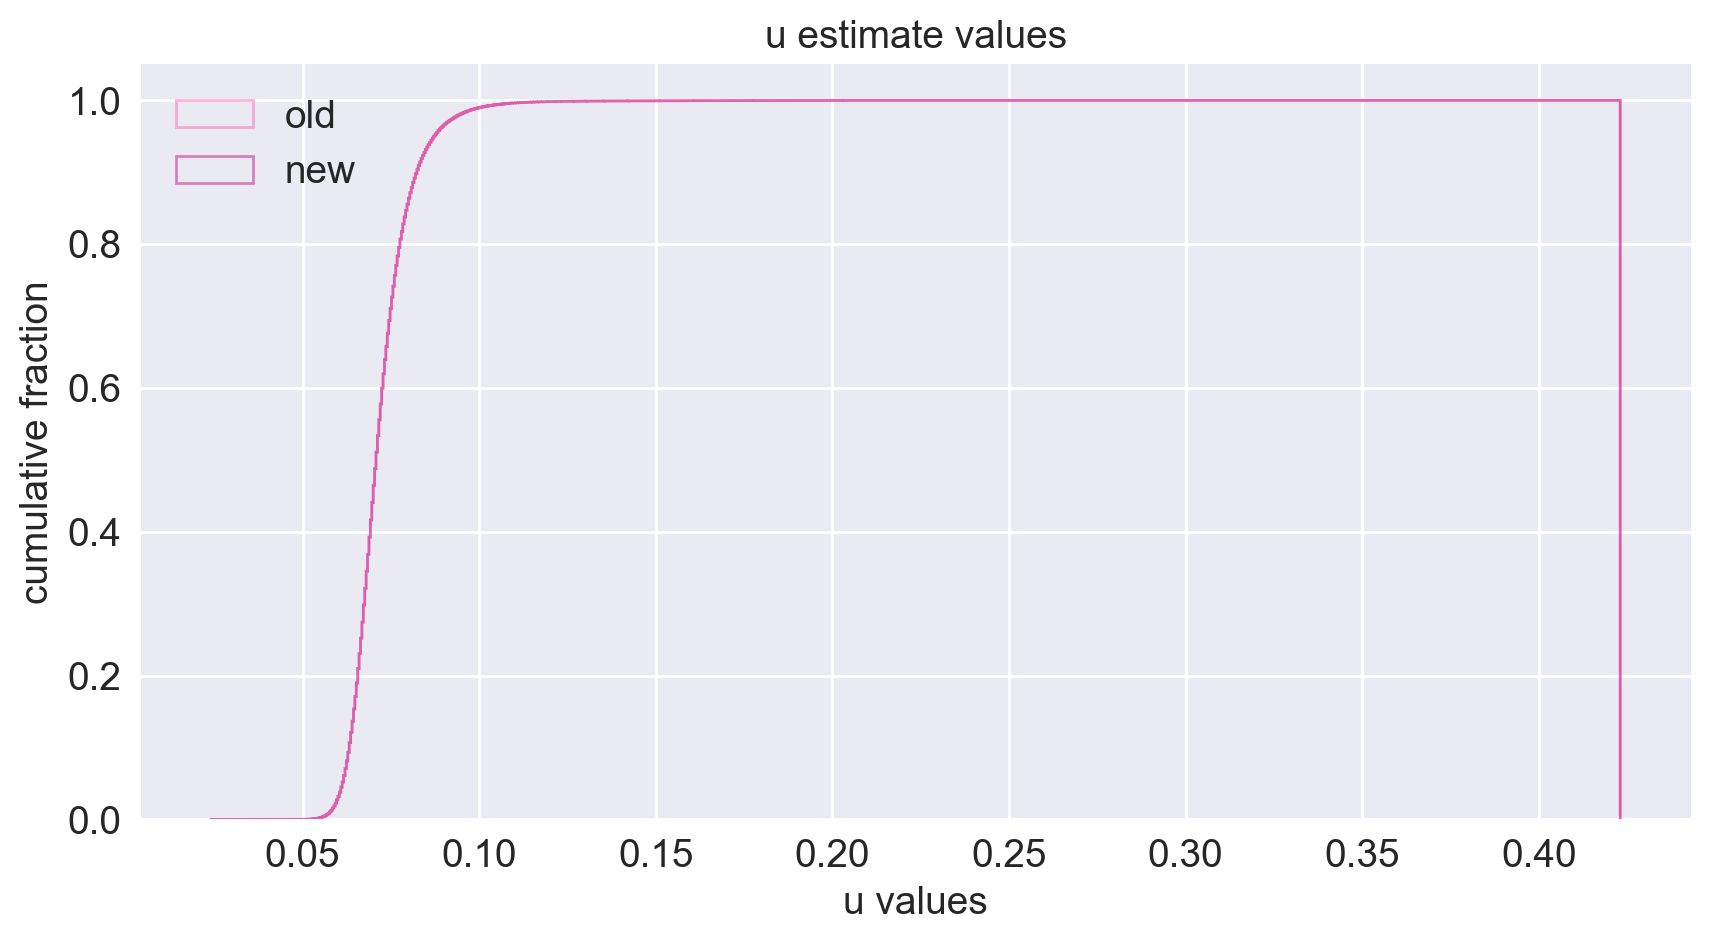

In [99]:
# neutral u checks
cum = 1
dfmt = dict(bins=1000, cumulative=cum, normed=cum, histtype='step', lw=1, alpha=0.5)

plt.figure(figsize=(10,5))
plt.title('u estimate values', fontsize=14)
plt.hist(u1, weights=d1, color=cols[0], label='old', **dfmt)
plt.hist(u2, weights=d2, color=cols[1], label='new', **dfmt)
plt.xlabel('u values', fontsize=14)
plt.xticks(fontsize=14)
plt.ylabel('cumulative fraction', fontsize=14)
plt.yticks(fontsize=14)
plt.legend(prop=dict(size=14), loc='upper left')
plt.show()

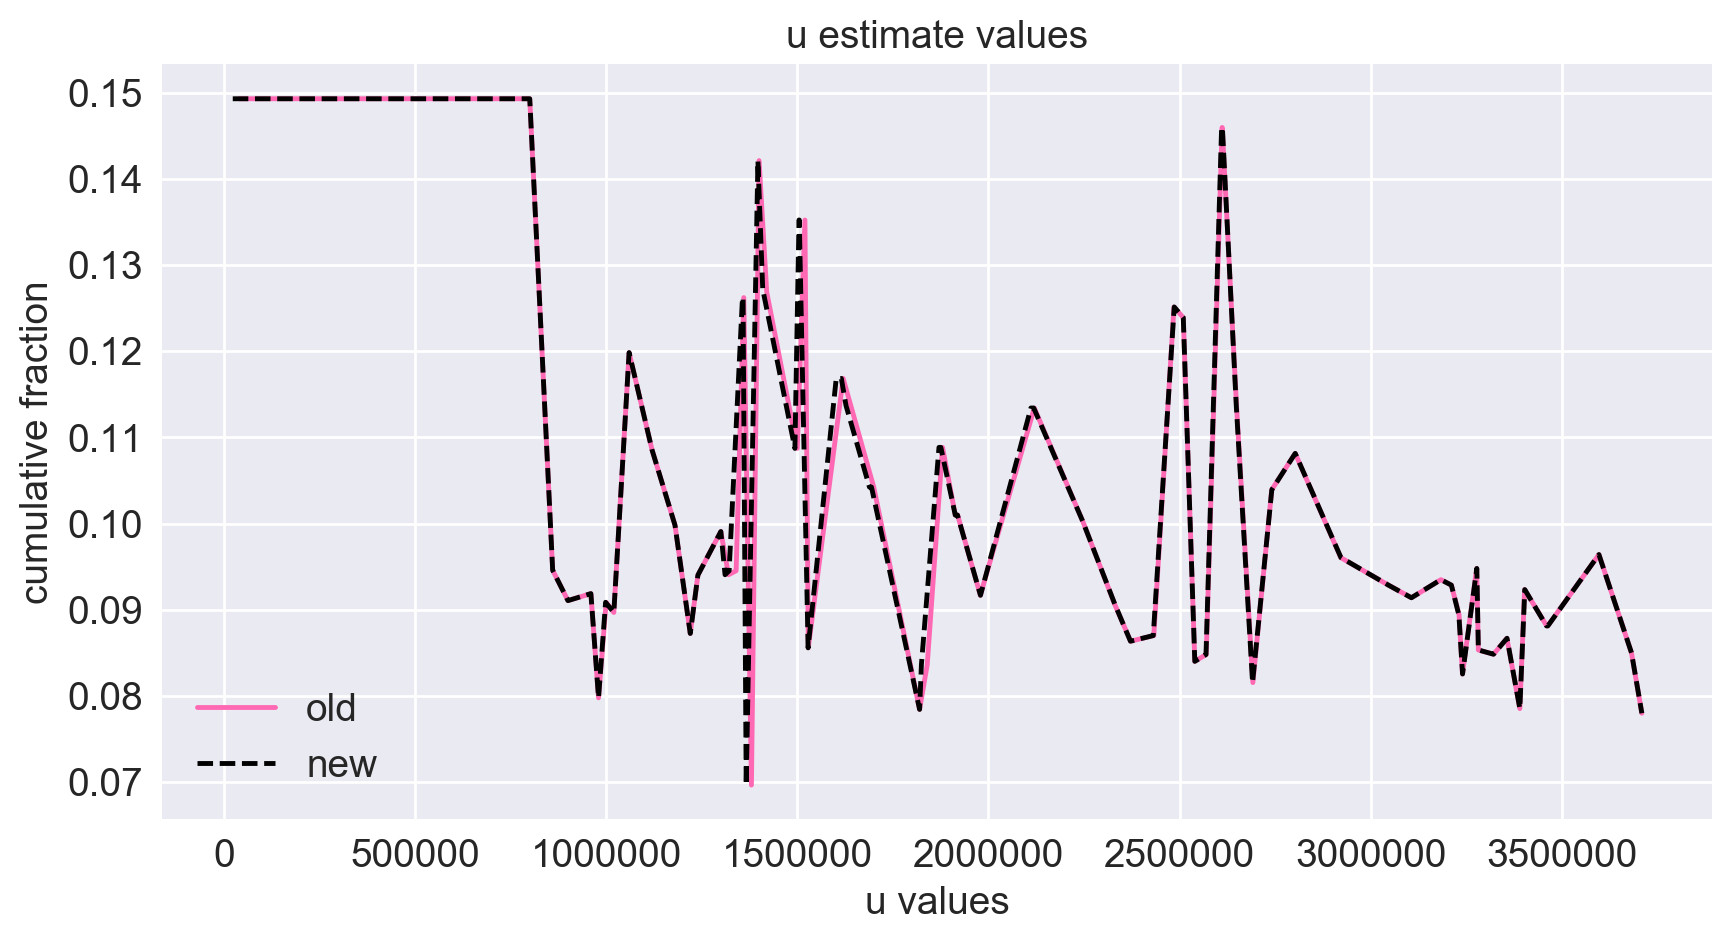

In [100]:
# sample of neutral u
cum1 = np.cumsum(s1)
cum2 = np.cumsum(s2)

p = randint_unique(1e5, start=1, end=cum1[-1])

i1 = np.searchsorted(cum1, p)
i2 = np.searchsorted(cum2, p)

(u1[i1] == u2[i2]).all()

plt.figure(figsize=(10,5))
plt.title('u estimate values', fontsize=14)
plt.plot(cum1[i1][:100], u1[i1][:100], color=cols[0], label='old')
plt.plot(cum2[i2][:100], u2[i2][:100], 'k--', label='new')
plt.xlabel('position (bp)', fontsize=14)
plt.xticks(fontsize=14)
plt.ylabel('u values', fontsize=14)
plt.yticks(fontsize=14)
plt.legend(prop=dict(size=14), loc='lower left')
plt.show()

---
# b values in final map weighted by neutral sites

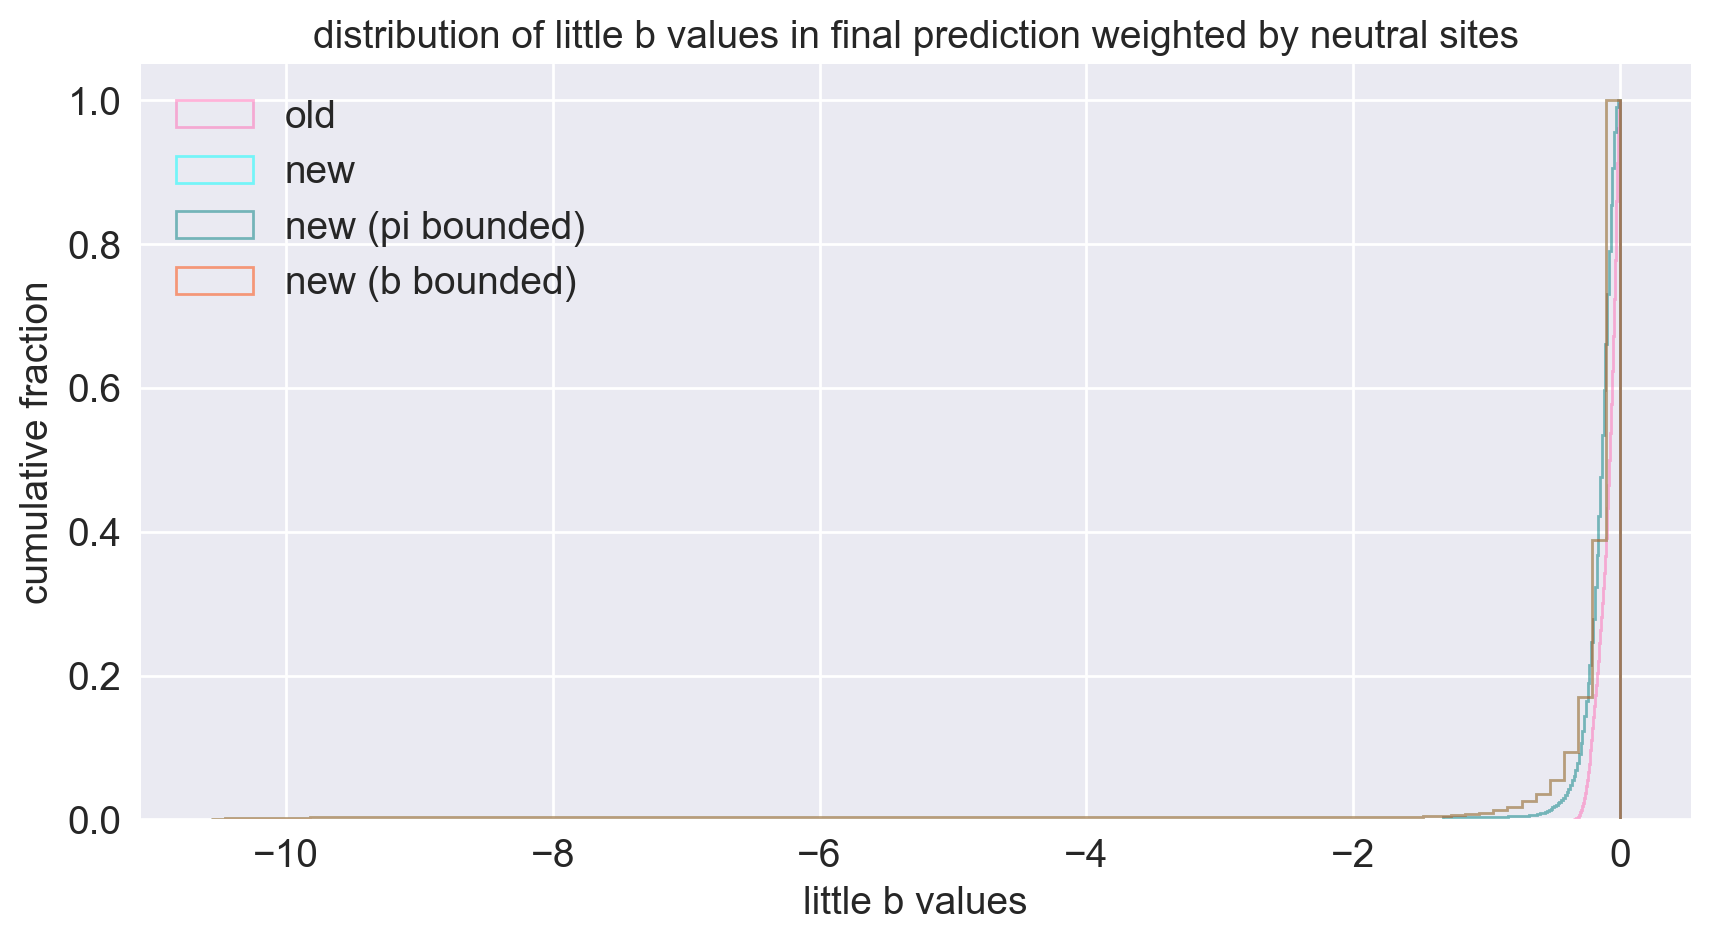

In [110]:
# proportion of neutral sites per binned b values
cum = 1
dfmt = dict(bins=100, cumulative=cum, normed=cum, histtype='step', lw=1, alpha=0.5)

plt.figure(figsize=(10,5))
plt.title('distribution of little b values in final prediction weighted by neutral sites', fontsize=14)
plt.hist(pb1, weights=d1[m1], color=cols[0], label='old', **dfmt)
plt.hist(pb2, weights=d2[m2], color=cols[4], label='new', **dfmt)
plt.hist(pb3, weights=d2[m2], color=cols[5], label='new (pi bounded)', **dfmt)
plt.hist(pb4, weights=d2[m2], color=cols[3], label='new (b bounded)', **dfmt)

plt.xlabel('little b values', fontsize=14)
plt.xticks(fontsize=14)
plt.ylabel('cumulative fraction', fontsize=14)
plt.yticks(fontsize=14)
plt.legend(prop=dict(size=14), loc='upper left')
plt.show()

---
# pi values in final maps weighted by neutral sites

In [102]:
# pi maps
pr1 = predicted_pi(cs_old.params, cs_old, u1[m1], b1[m1], None)
pr2 = predicted_pi(cs[1].params, cs[1], u2[m2], b2[m2], None)
pr3 = predicted_pi(cs_new.params, cs_new, u2[m2], b2[m2], None)
pr4 = predicted_pi(cs[3].params, cs[3], u2[m2], b2[m2], None)

cum = False
dfmt = dict(bins=100, cumulative=cum, normed=cum, histtype='step', lw=1, alpha=0.5)

plt.figure(figsize=(10,5))
plt.title('distribution of predicted pi values', fontsize=14)

plt.hist(pr1, weights=d1[m1], color=cols[0], label='old', **dfmt)
plt.hist(pr2, weights=d2[m2], color=cols[4], label='new', **dfmt)
plt.hist(pr3, weights=d2[m2], color=cols[5], label='new (pi bounded)', **dfmt)
plt.hist(pr4, weights=d2[m2], color=cols[3], label='new (b bounded)', **dfmt)

plt.xlabel('pi values', fontsize=14)
plt.xticks(fontsize=14)
plt.ylabel('cumulative fraction', fontsize=14)
plt.yticks(fontsize=14)
plt.legend(prop=dict(size=14), loc='upper left')
plt.show()

---
# b values weighted by _neutral_ covered and _neutral poly_ covered

In [ ]:
# get b bins
i = 0
bn1 = np.unique(b1[:,i])
bn2 = np.unique(b2[:,i])
bns = np.unique(np.concatenate((bn1, bn2)))
# bnsx = np.concatenate(([bns.min()], bn1))

# count sites per b bin
ct1 = np.histogram(b1[:,i], bins=bns, weights=d1)[0].astype(float)
ct2 = np.histogram(b2[:,i], bins=bns, weights=d2)[0].astype(float)

ctp1 = np.histogram(b1[:,i], bins=bns, weights=d1*(n1[:,1]>1).astype(int))[0].astype(float)
ctp2 = np.histogram(b2[:,i], bins=bns, weights=d2*(n2[:,1]>1).astype(int))[0].astype(float)
# ct1 = np.histohgram(b1[:,i], bins=bn1, weights=d1)[0].astype(float)
# ct2 = np.histogram(b2[:,i], bins=bn2, weights=d2)[0].astype(float)

In [90]:
plt.figure(figsize=(10,5))
plt.step(bns[1:], np.cumsum(ctp1)/np.sum(ctp1, dtype='f8'), lw=1, alpha=0.8, color=cols[0])
plt.step(bns[1:], np.cumsum(ctp2)/np.sum(ctp2, dtype='f8'), lw=1, alpha=0.8, color=cols[2])
# plt.step(np.exp(bns[1:]), np.cumsum(ct1)/np.sum(ct1, dtype='f8'), lw=1, alpha=0.8, color=cols[0])
# plt.step(np.exp(bns[1:]), np.cumsum(ct2)/np.sum(ct2, dtype='f8'), lw=1, alpha=0.8, color=cols[2])
plt.xlim(-35, 1)
plt.show()

/Users/davidmurphy/anaconda2/lib/python2.7/site-packages/matplotlib/cbook.py:2641: UserWarning: Saw kwargs [u'ls', u'linestyle'] which are all aliases for u'linestyle'.  Kept value from u'linestyle'
  seen=seen, canon=canonical, used=seen[-1]))


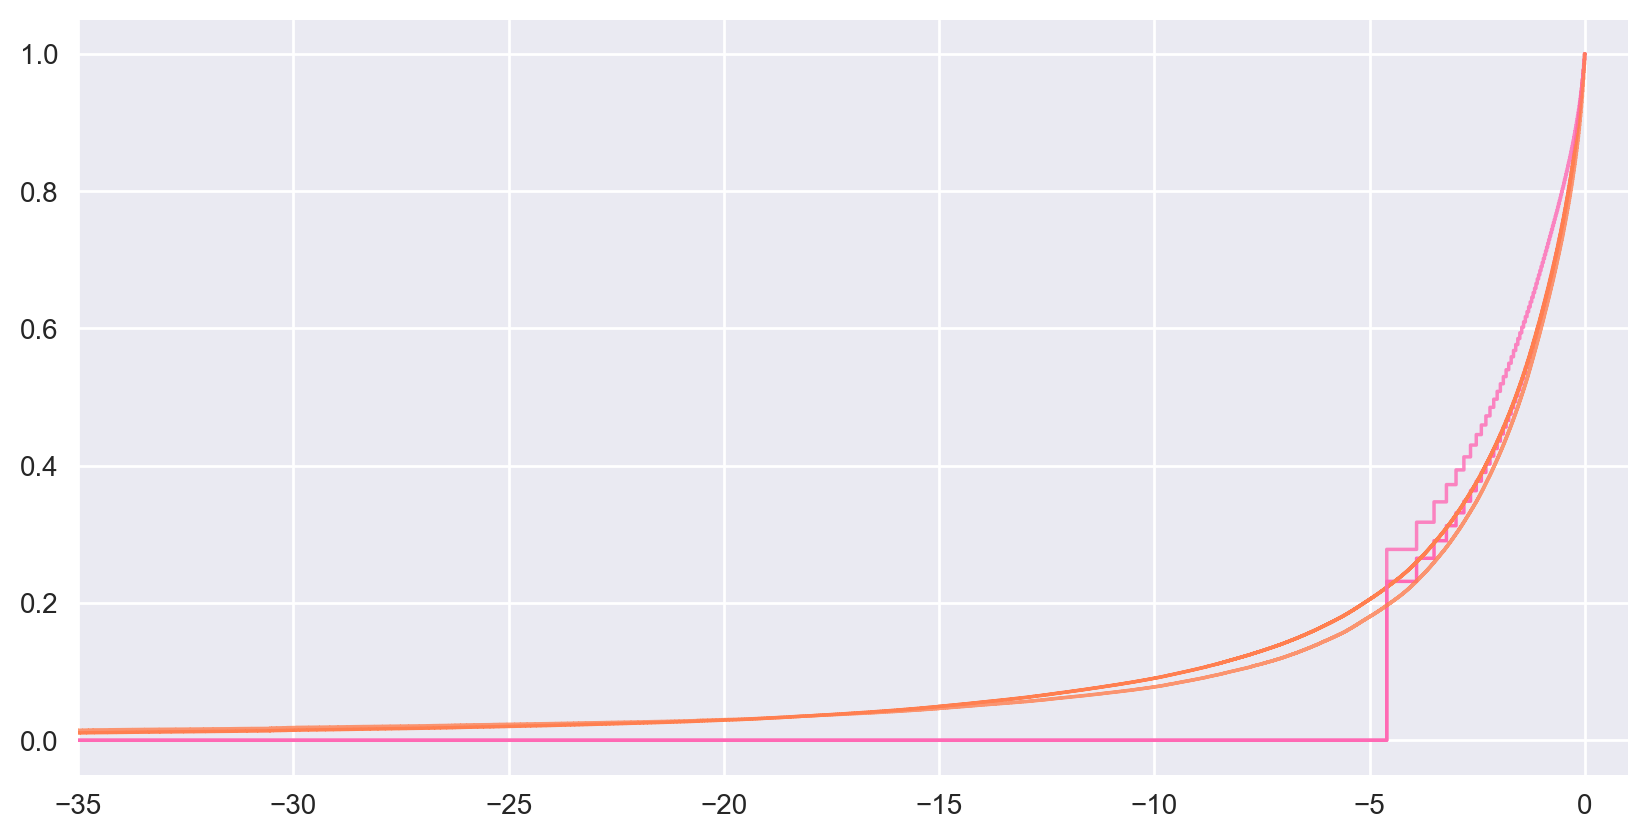

In [97]:
plt.figure(figsize=(10,5))
plt.step(bns[1:], np.cumsum(ct1)/np.sum(ct1, dtype='f8'), lw=1.25, color=cols[0], label='old')
plt.step(bns[1:], np.cumsum(ct2)/np.sum(ct2, dtype='f8'), lw=1.25, color=cols[2], label='new')
plt.step(bns[1:], np.cumsum(ctp1)/np.sum(ctp1, dtype='f8'), ls='--', lw=1.25, alpha=0.8, color=cols[0], label='old poly')
plt.step(bns[1:], np.cumsum(ctp2)/np.sum(ctp2, dtype='f8'), ls='--', lw=1.25, alpha=0.8, color=cols[2], label='new poly')
# plt.step(np.exp(bns[1:]), np.cumsum(ct1)/np.sum(ct1, dtype='f8'), lw=1, alpha=0.8, color=cols[0])
# plt.step(np.exp(bns[1:]), np.cumsum(ct2)/np.sum(ct2, dtype='f8'), lw=1, alpha=0.8, color=cols[2])
plt.xlim(-35, 1)
plt.show()

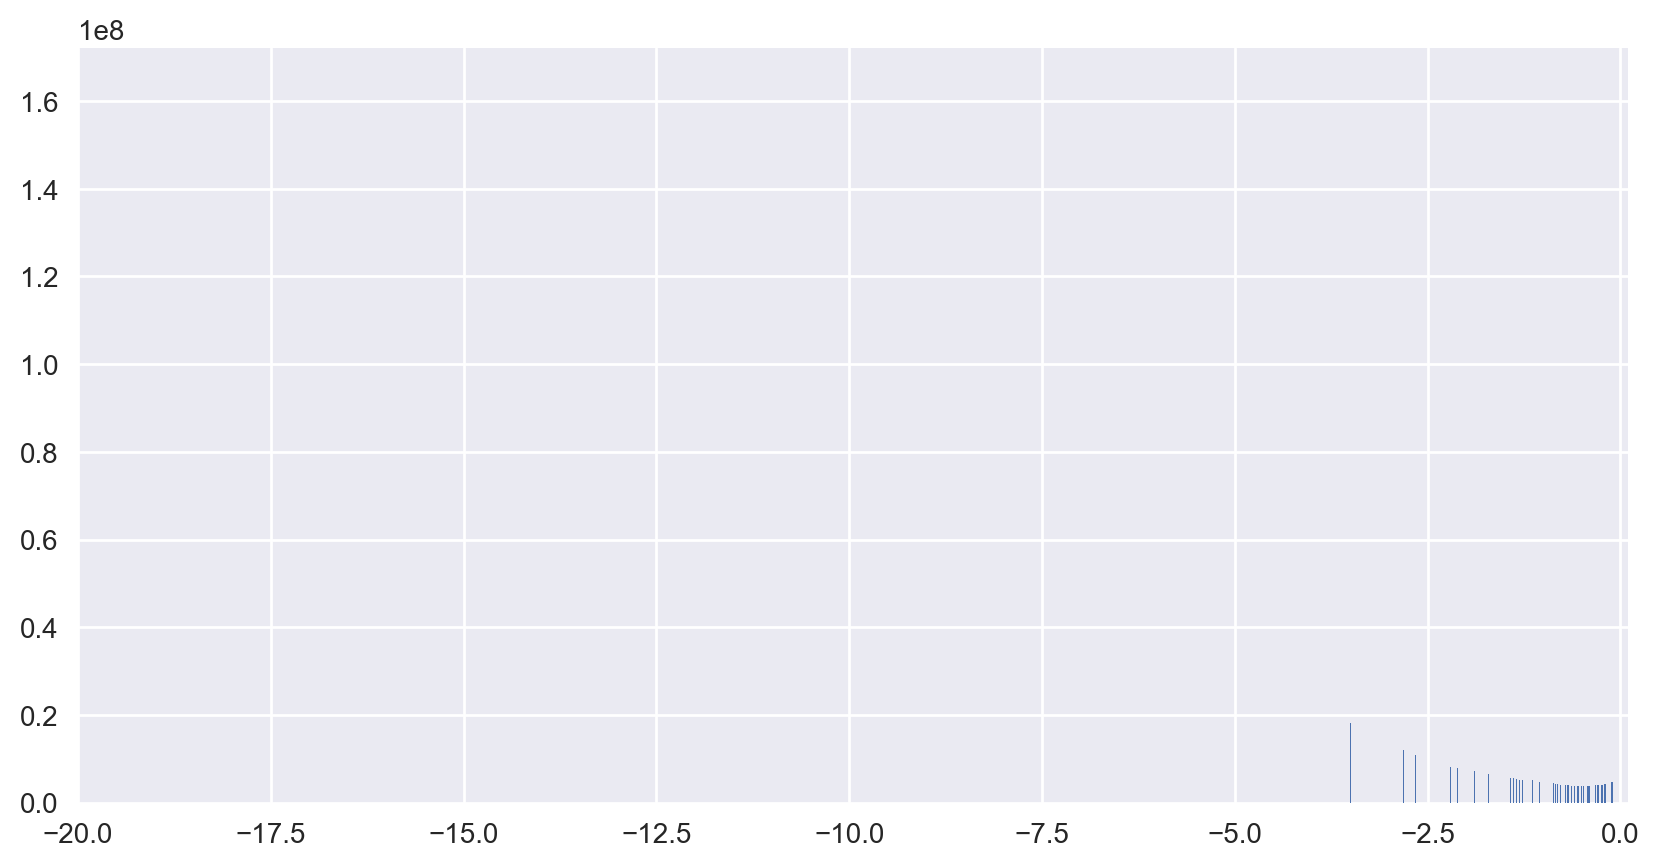

In [72]:
plt.hist(b2[:,i], bins=bns, weights=d2)

# plt.step(bnsx[1:], ct1 / np.sum(ct1, dtype='f8'), lw=0.8, alpha=0.8, color=cols[0])
# plt.step(bnsx[1:], ct2 / np.sum(ct2, dtype='f8'), lw=0.8, alpha=0.8, color=cols[2])
# plt.step(bn1[1:], ct1 / np.sum(ct1, dtype='f8'), lw=0.8, alpha=0.8, color=cols[0])
# plt.step(bn2[1:], ct2 / np.sum(ct2, dtype='f8'), lw=0.8, alpha=0.8, color=cols[2])

plt.xlim(-20, 0.1)
plt.show()

In [55]:
np.sum(ct2, dtype='f8'), np.sum(ct1, dtype='f8')

(708591572.0, 708591572.0)

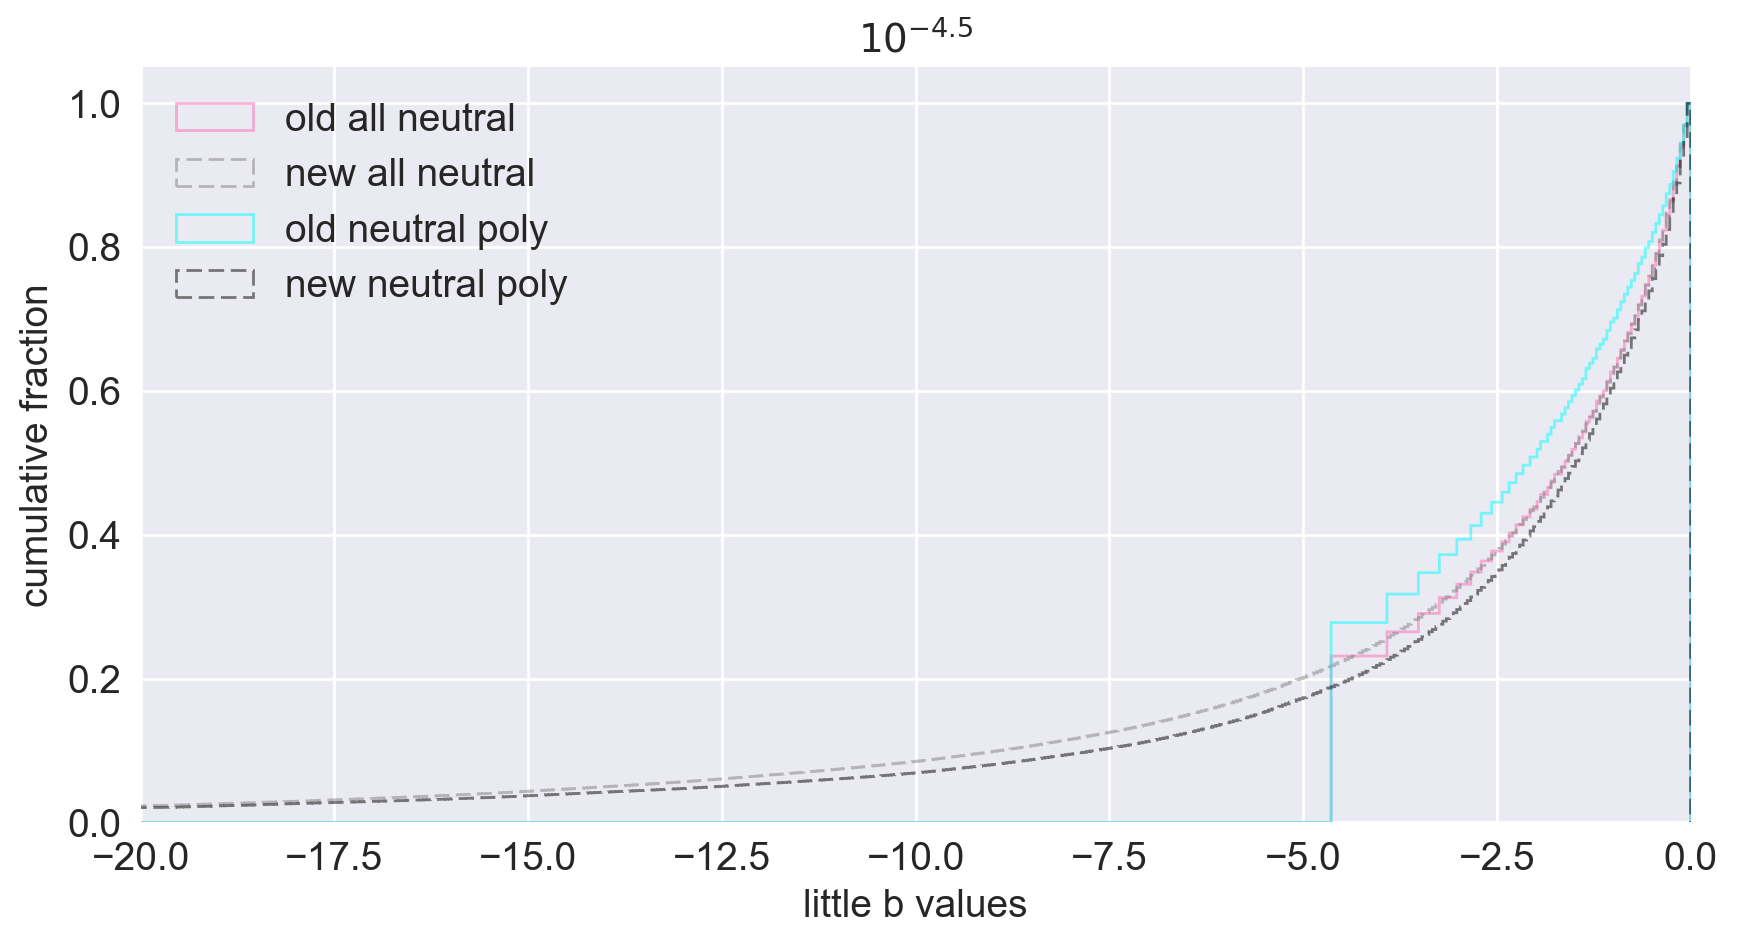

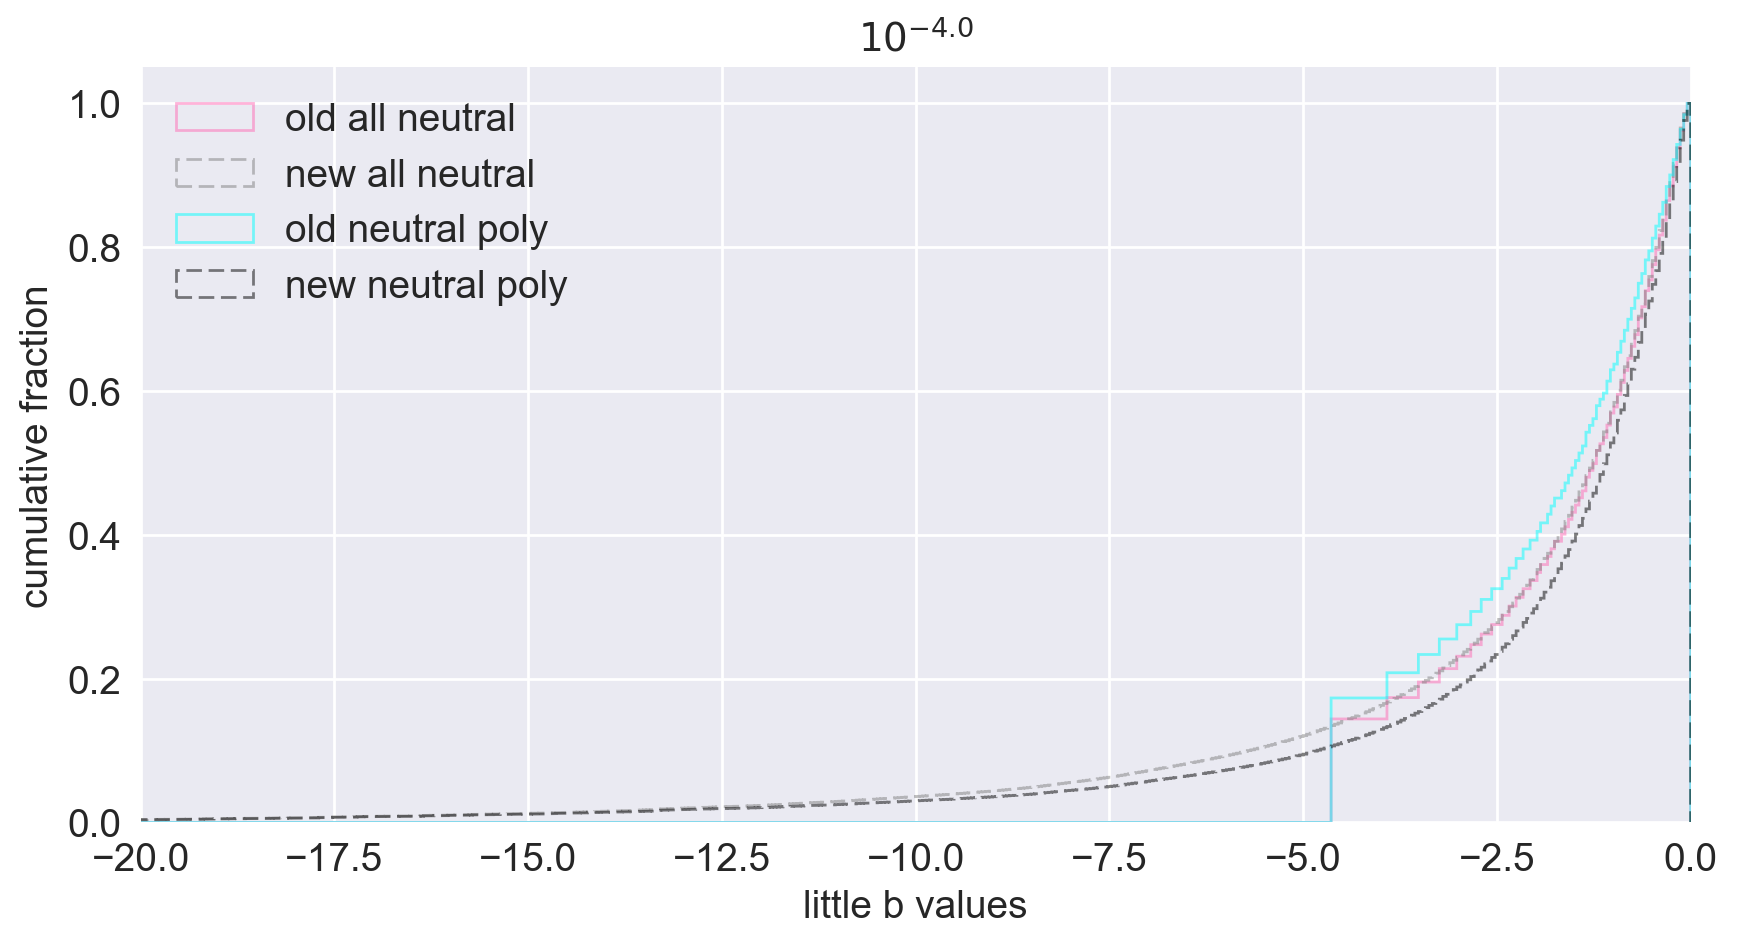

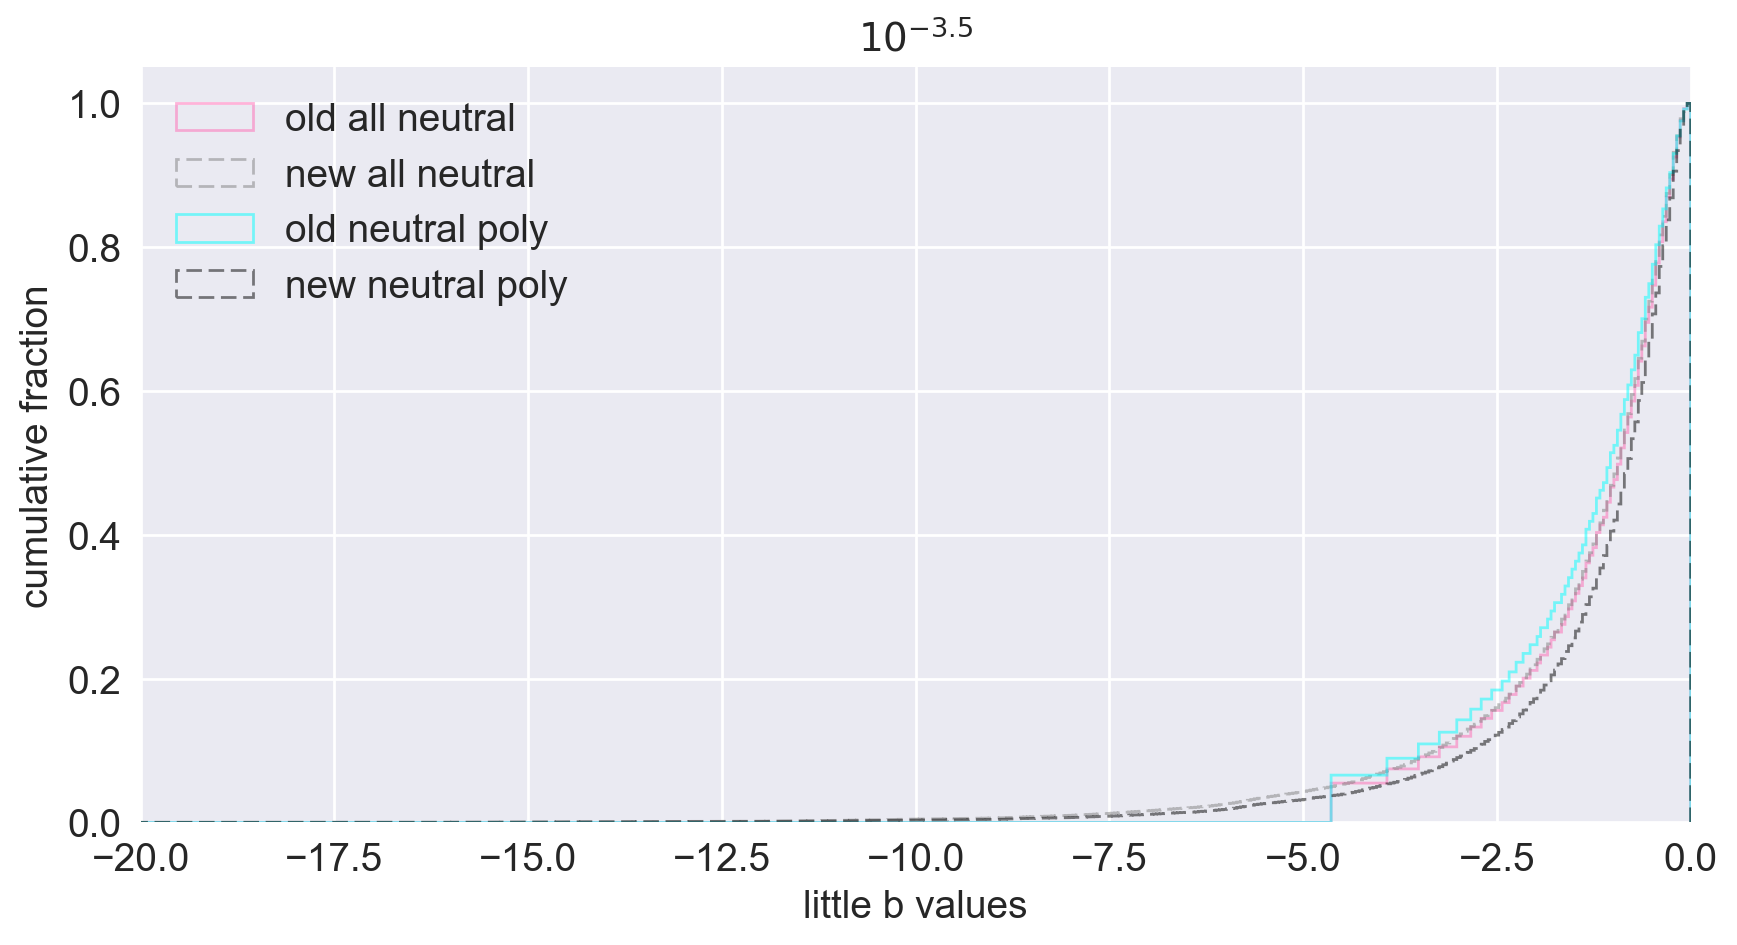

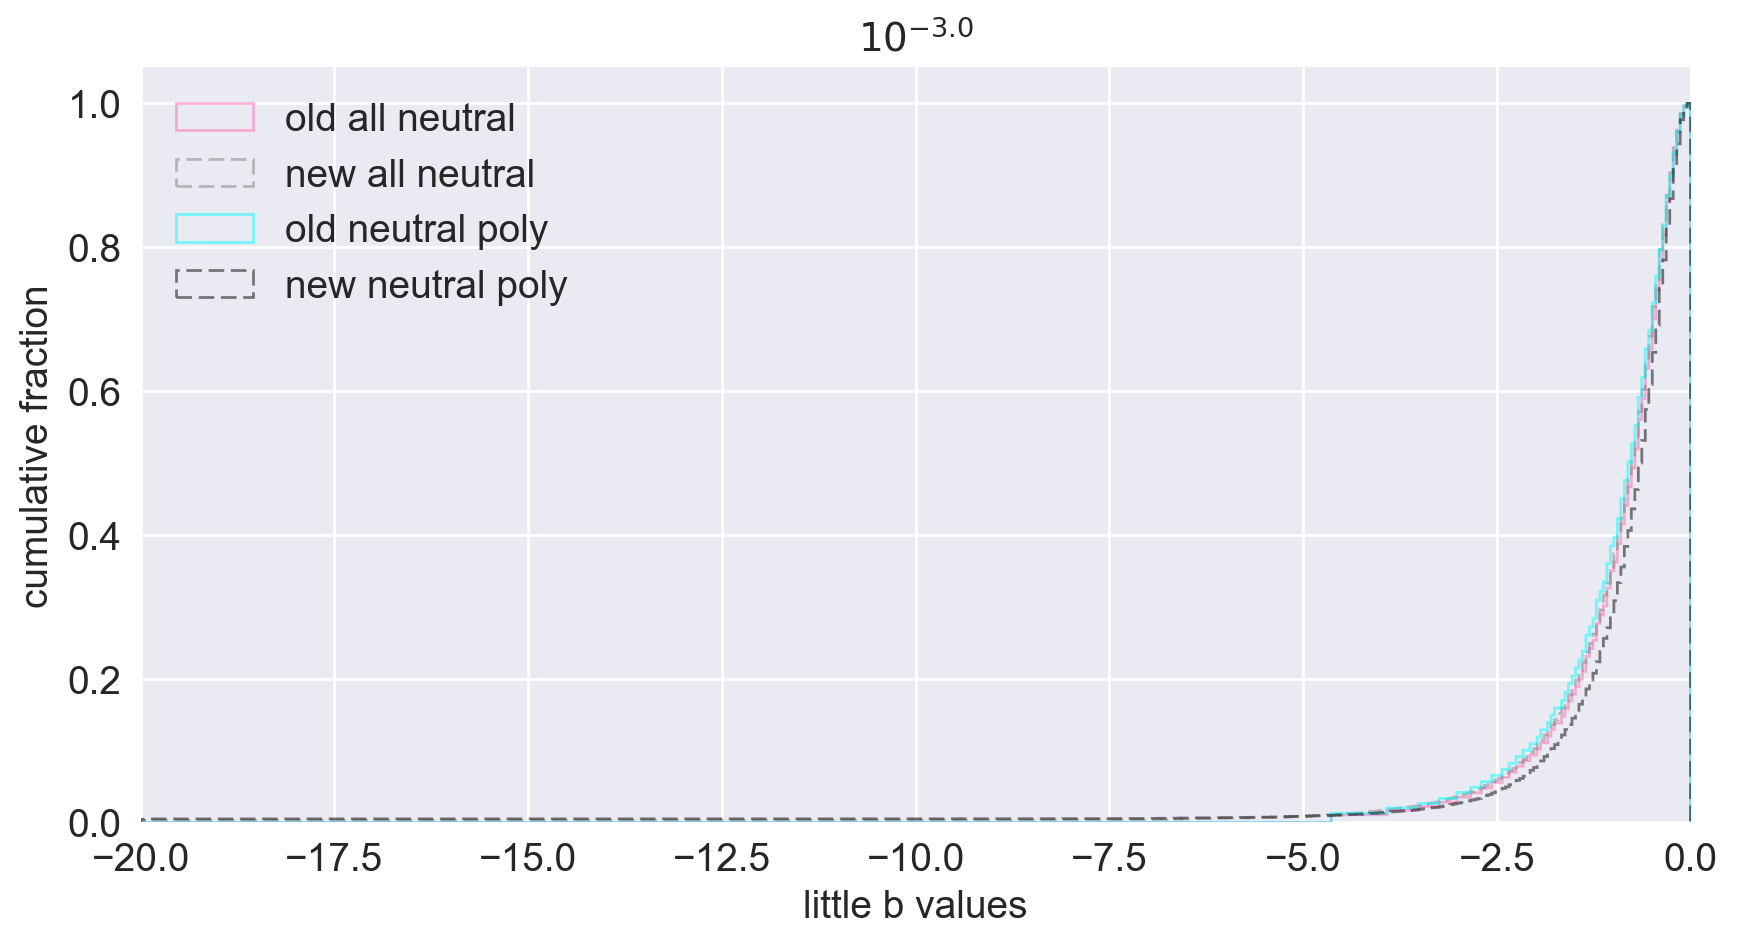

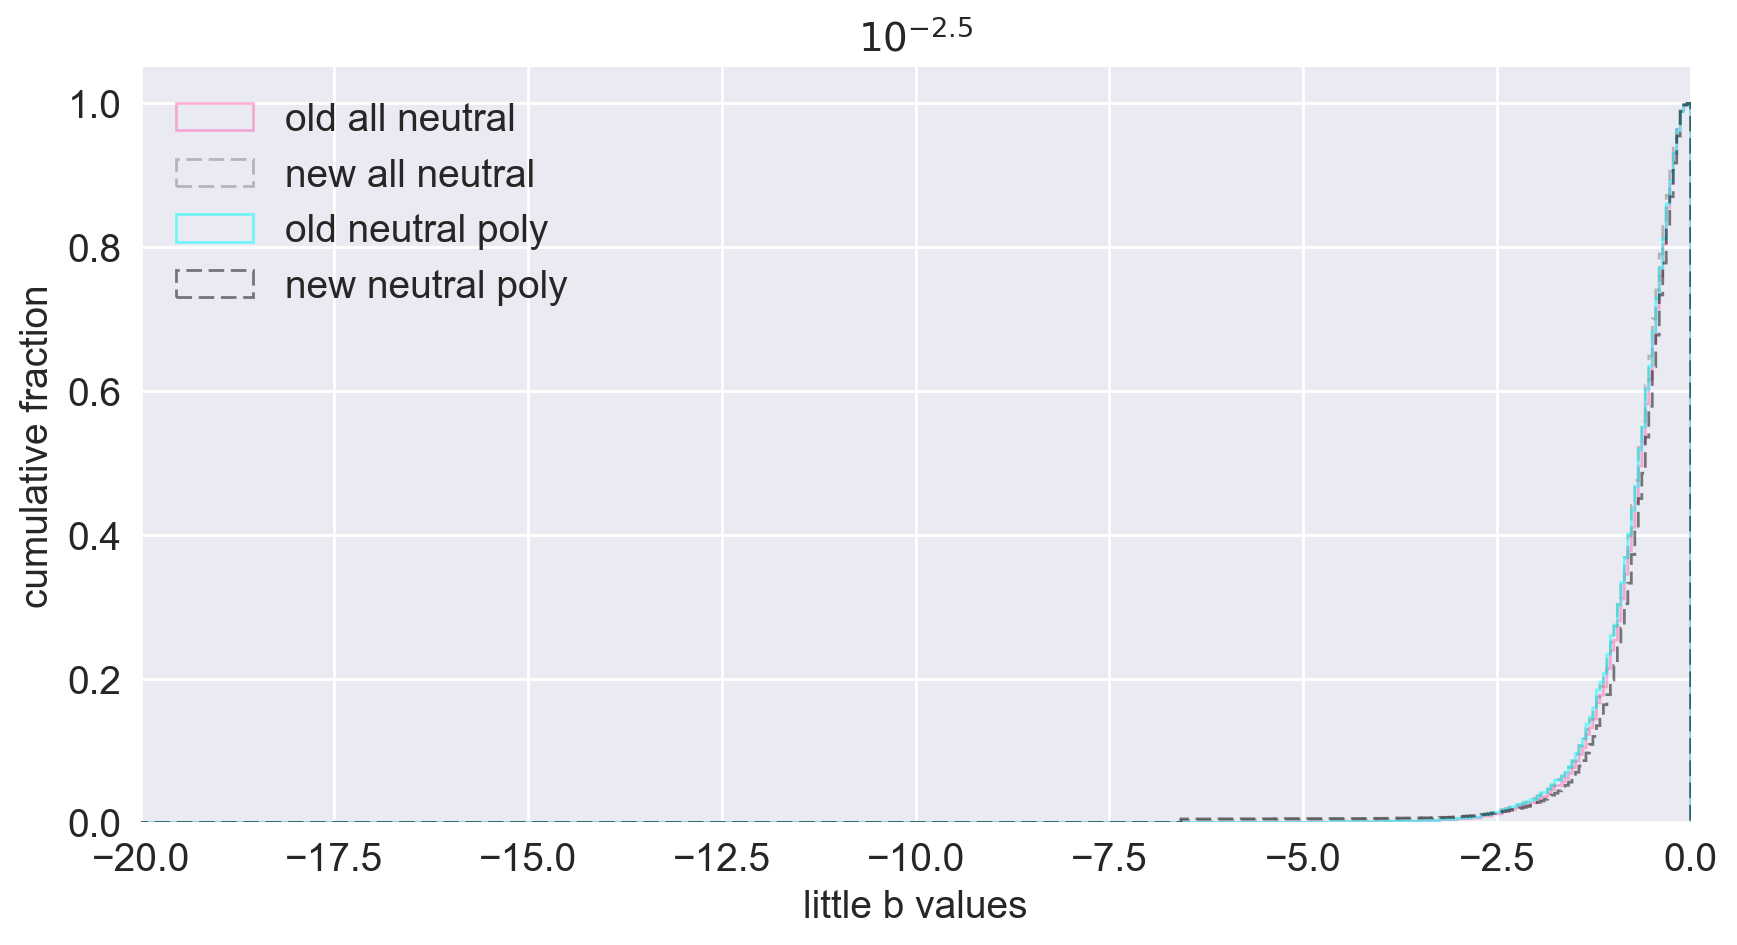

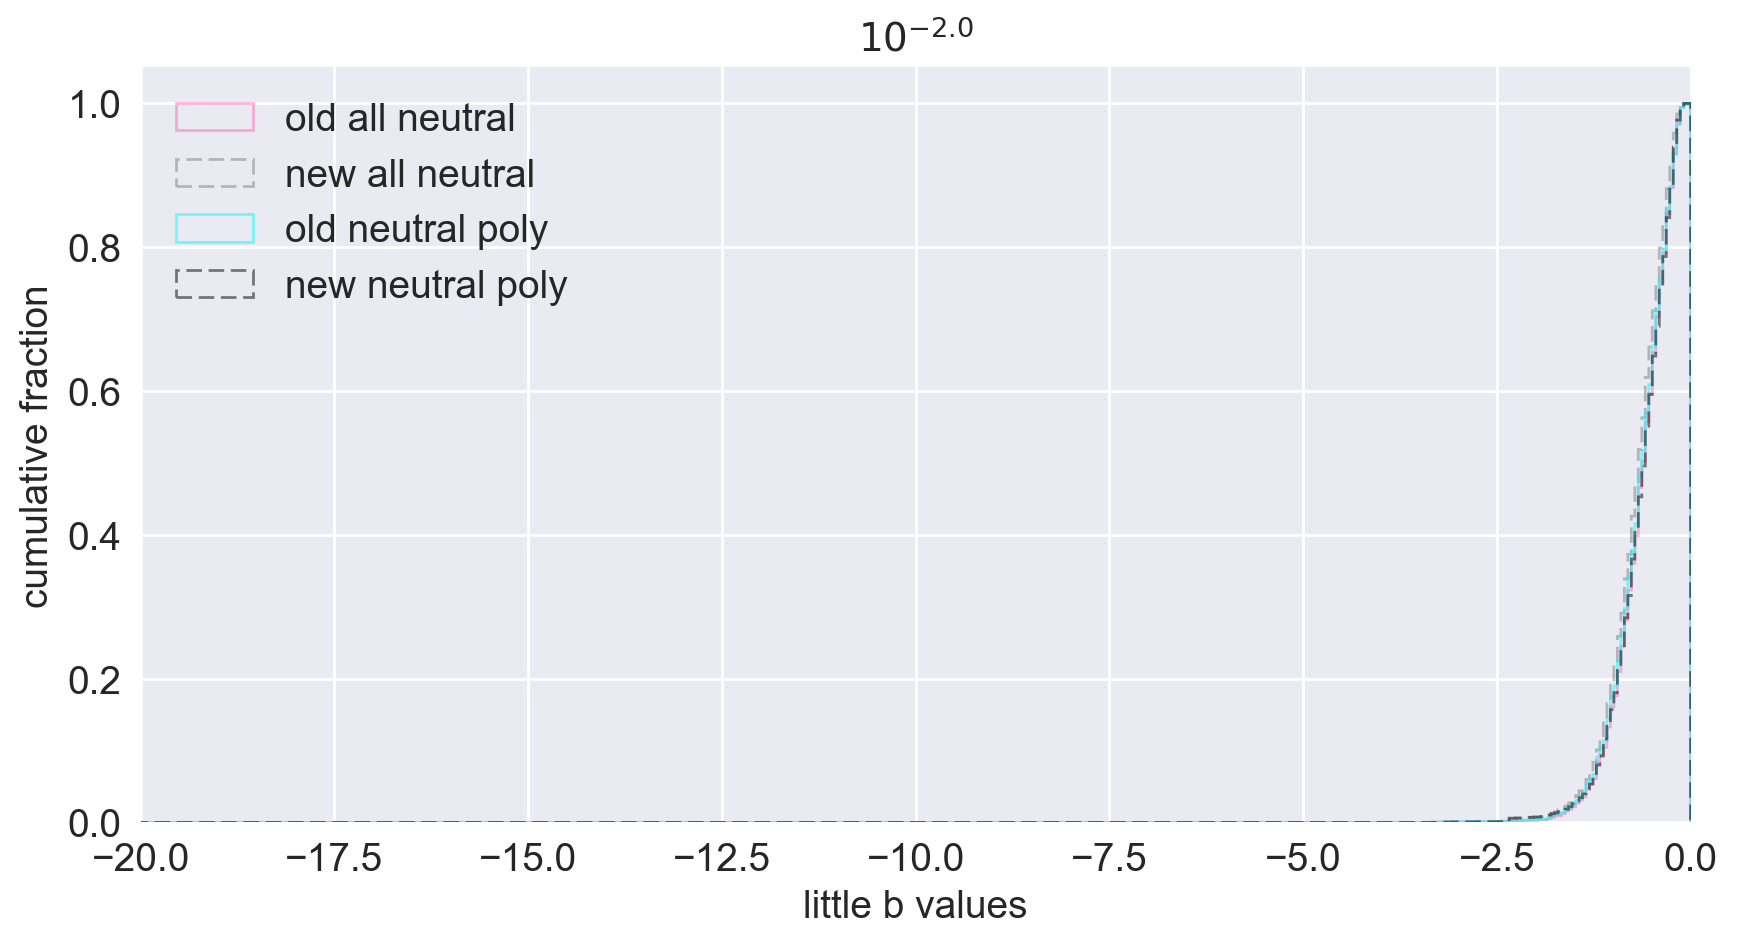

In [117]:
bins = np.linspace(-45, 0, 1000)
tvals = np.linspace(-4.5, -2.0, 6)

cum = 1
dfmt = dict(bins=bins, cumulative=cum, normed=cum, histtype='step', lw=1, alpha=0.5)

for i in xrange(6):
    plt.figure(figsize=(10,5))
    plt.title(r'$10^{%.1f}$' % tvals[i], fontsize=14)
    plt.hist(b1[m1][:, i], weights=d1[m1],color=cols[0], label='old all neutral', **dfmt)
    plt.hist(b2[m2][:, i], weights=d2[m2], ls = '--', color='grey', label='new all neutral', **dfmt)
    plt.hist(b1[m1][mp1][:, i], weights=d1[m1][mp1], color=cols[4], label='old neutral poly', **dfmt)
    plt.hist(b2[m2][mp2][:, i], weights=d2[m2][mp2], ls = '--', color='k', label='new neutral poly', **dfmt)
    plt.xlabel('little b values', fontsize=14)
    plt.xticks(fontsize=14)
    plt.ylabel('cumulative fraction', fontsize=14)
    plt.yticks(fontsize=14)
    plt.legend(prop=dict(size=14), loc='upper left')
    plt.xlim(-20, 0)
    plt.show()


---
# b values weighted by bases covered

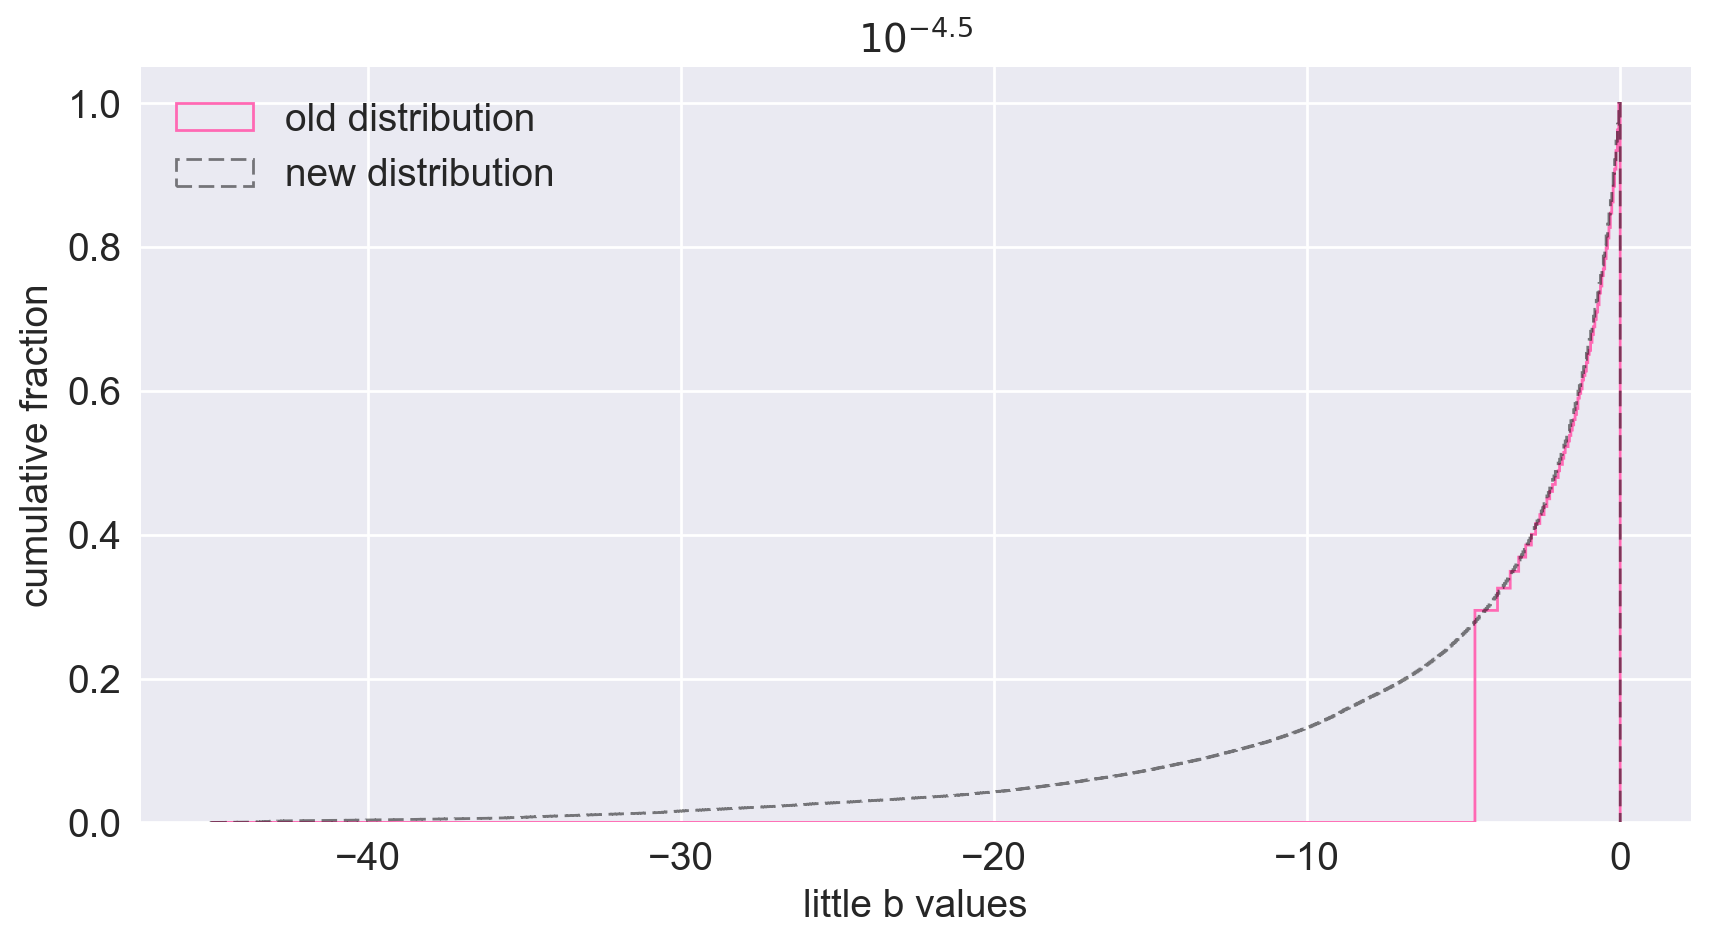

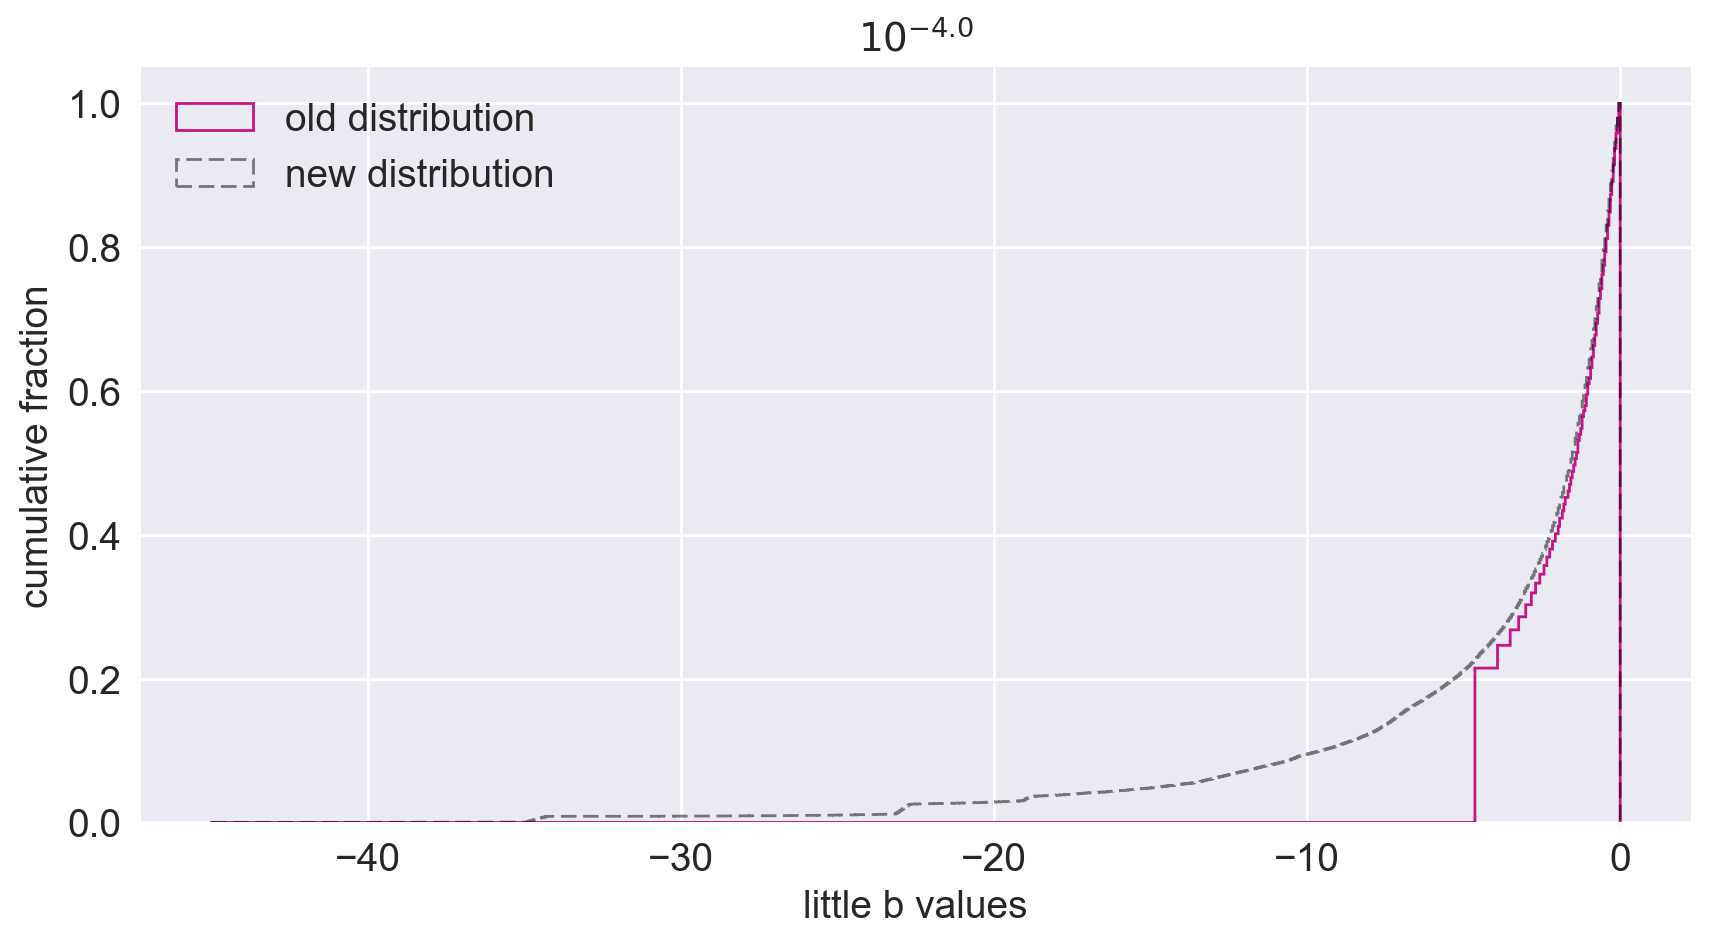

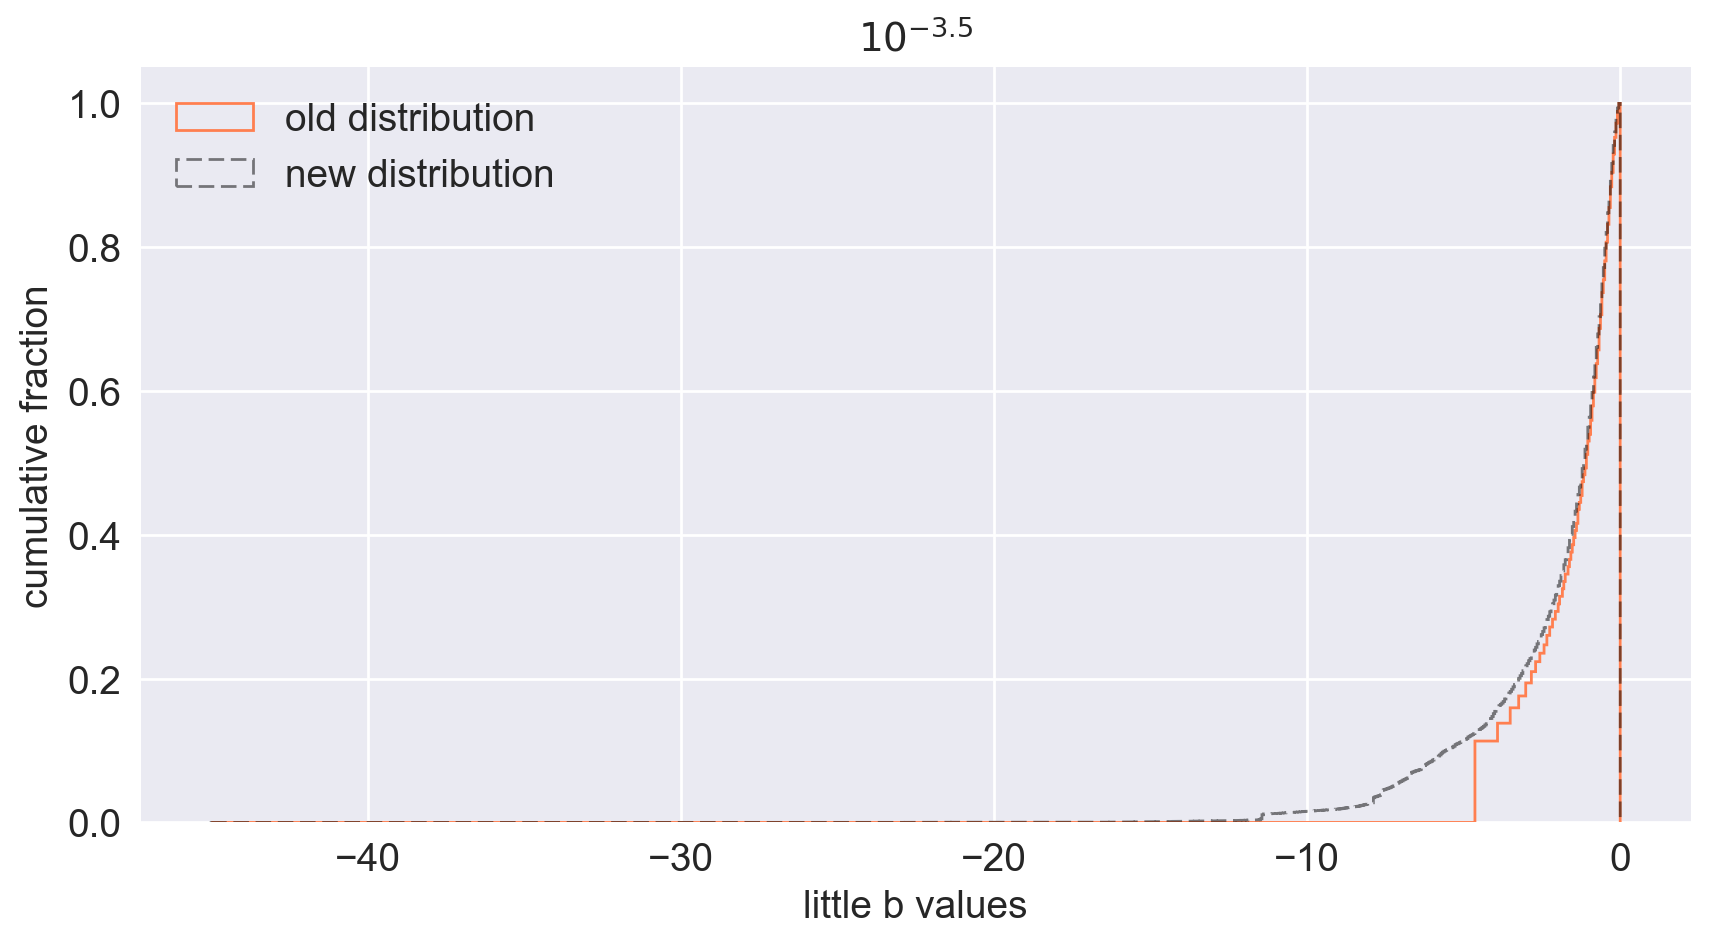

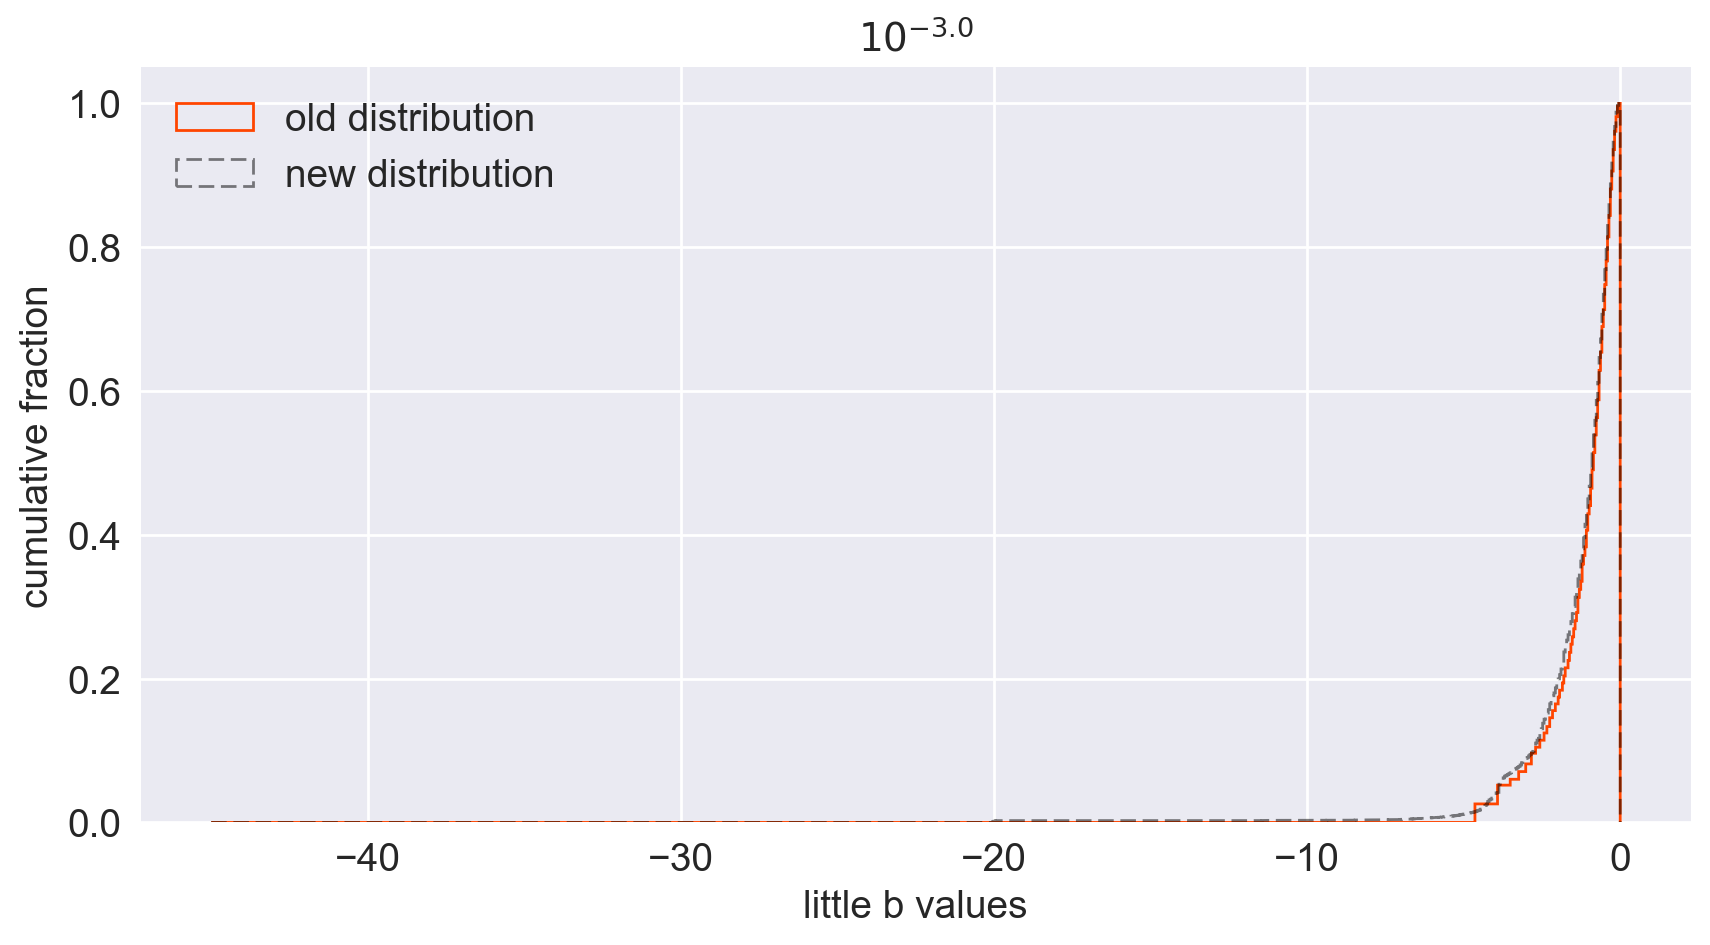

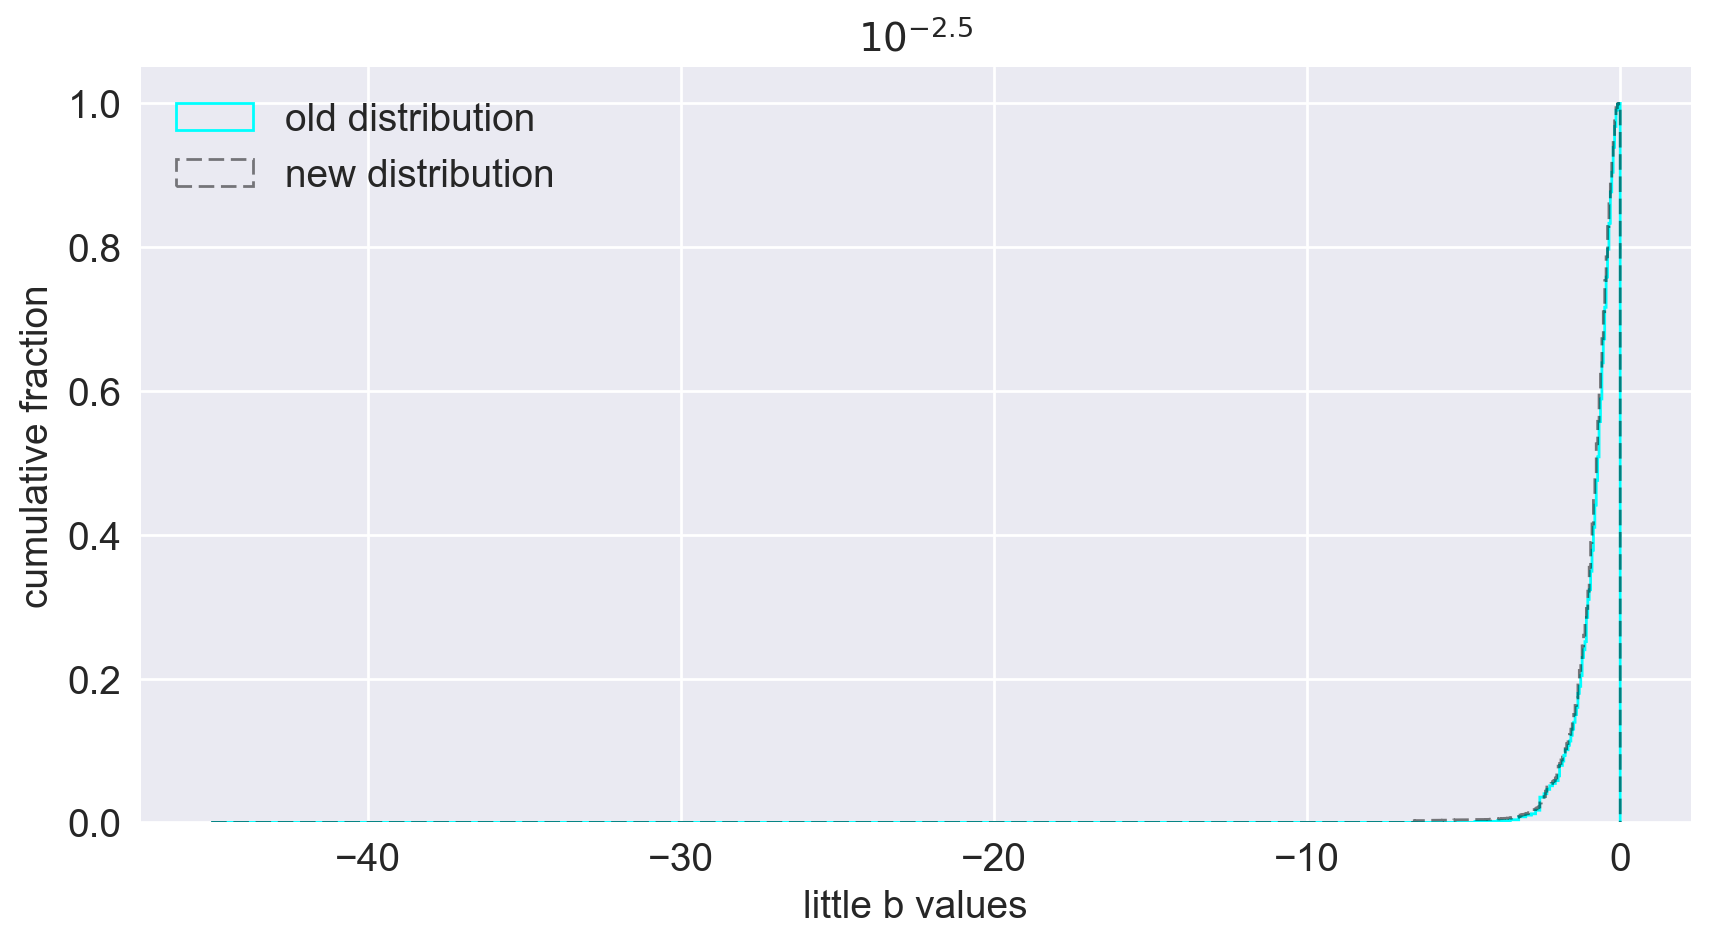

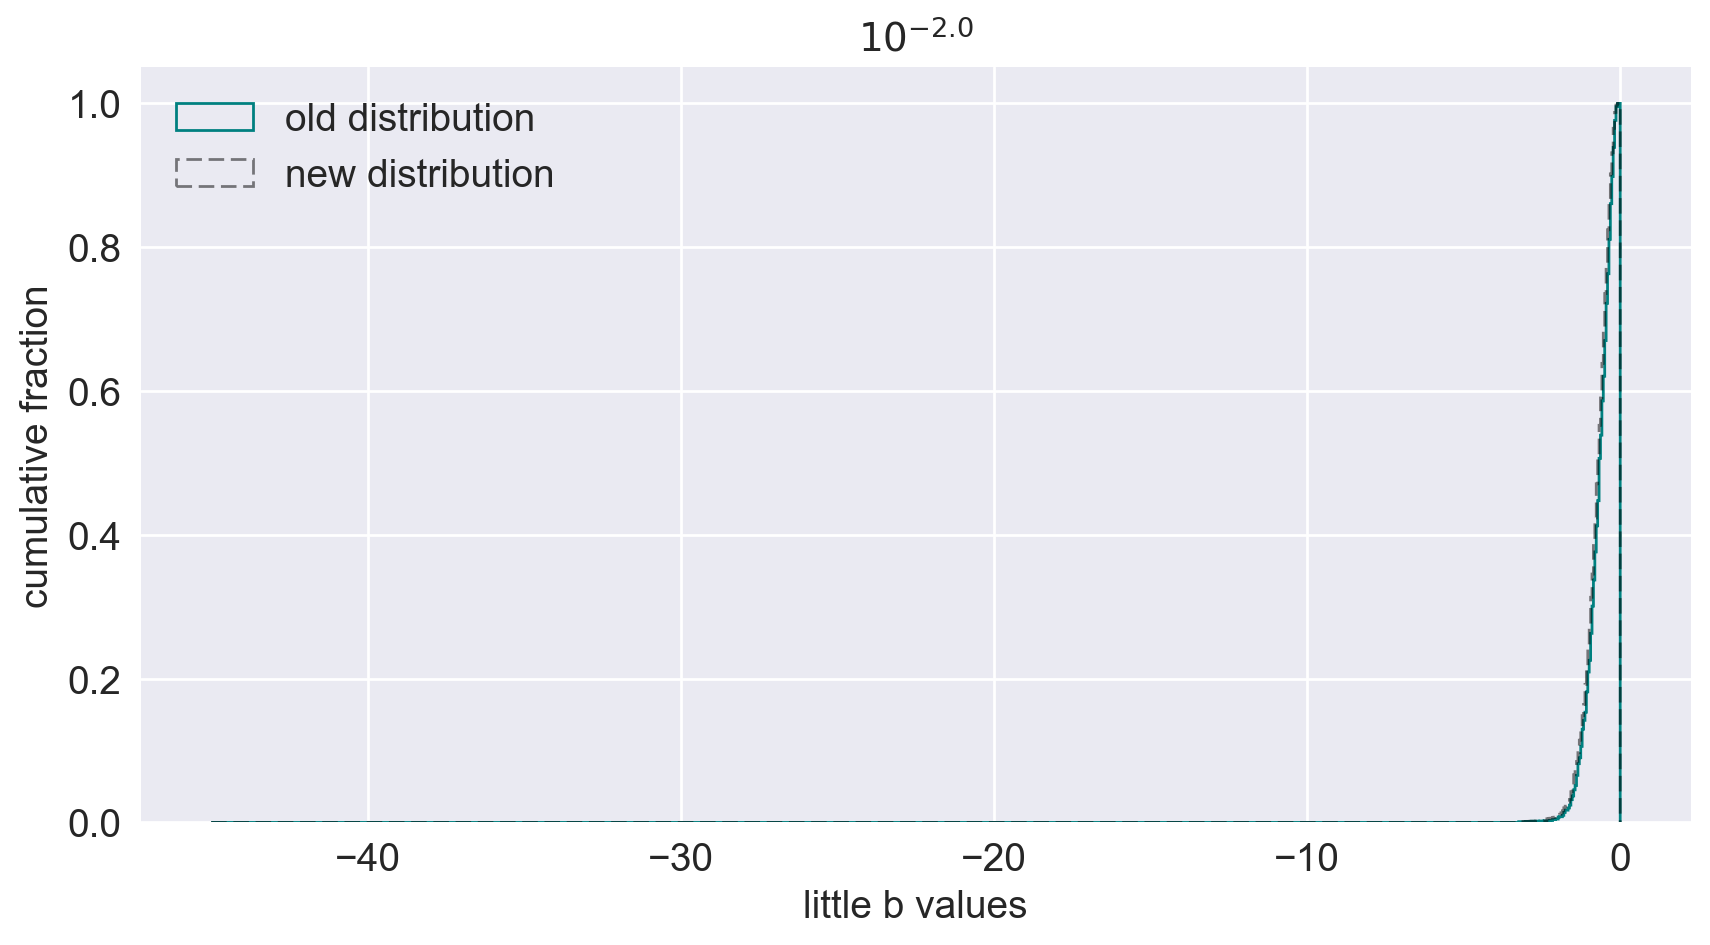

In [78]:

for i in xrange(6):
    plt.figure(figsize=(10,5))
    plt.title(r'$10^{%.1f}$' % tvals[i], fontsize=14)
    plt.hist(b1[:, i], bins=bins, cumulative=1, normed=1, weights=s1,
             histtype='step', lw=1, color=cols[i], label='old distribution')
    plt.hist(b2[:, i], bins=bins, cumulative=1, normed=1, weights=s2,
             histtype='step', lw=1, ls = '--', color='k', alpha=0.5, label='new distribution')
    plt.xlabel('little b values', fontsize=14)
    plt.xticks(fontsize=14)
    plt.ylabel('cumulative fraction', fontsize=14)
    plt.yticks(fontsize=14)
    plt.legend(prop=dict(size=14), loc='upper left')
    plt.show()